# Manning's n Multi-Interval

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import HdfMesh, HdfResultsMesh, RasCmdr, RasExamples, RasGeo, RasPlan, init_ras_project, ras

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📦 PIP PACKAGE MODE: Loading installed ras-commander
✓ Loaded: C:\Users\bill\AppData\Roaming\Python\Python313\site-packages\ras_commander\__init__.py


## Parameters

Configure these values to customize the notebook for your project.

In [2]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "BaldEagleCrkMulti2D"  # Example project to extract
RAS_VERSION = "6.6"                   # HEC-RAS version

# Manning's Sensitivity Settings
PLAN = "03"                           # Template plan
PARAMETER_VALUES = [0.8, 0.9, 1.0, 1.1, 1.2]  # Manning's n multipliers
POINT_OF_INTEREST = (2081544, 365715)  # (x, y) for result extraction

# Execution Settings
RUN_PARALLEL = True
MAX_WORKERS = 4
NUM_CORES = 2


# Manning's n Sensitivity Analysis: Multi-Interval Approach

## Overview

This notebook demonstrates **regional Manning's n sensitivity analysis** for HEC-RAS 2D models with multiple roughness zones. This approach isolates the influence of individual regions rather than varying all parameters simultaneously.

### Sensitivity Analysis Methodology

**One-at-a-Time (OAT) Method**:
1. Establish baseline Manning's n values for all regions
2. Vary ONE region at a time while holding others constant
3. Measure water surface elevation change at point of interest
4. Calculate sensitivity metric: ΔWS E/ Δn for each region
5. Rank regions by sensitivity to prioritize calibration efforts

**Why Multi-Interval?**

- **Individual Attribution**: Isolates effect of each specific region
- **Calibration Strategy**: Identifies which regions need refinement
- **Data Prioritization**: Focuses field surveys on high-sensitivity areas
- **Interaction Detection**: Reveals if regions have coupled effects

### LLM Forward Principle: Professional Judgment

Manning's n calibration requires engineering expertise:
- **Physical Realism**: Parameters must match actual land cover
- **Observational Data**: Calibrate to measured water surfaces when available
- **Parameter Bounds**: Stay within physically defensible ranges
- **Model Purpose**: Calibration rigor depends on decision stakes

### Expected Sensitivity Patterns

**High Sensitivity Regions**:
- **Main channel**: Direct impact on conveyance
- **Floodplain upstream of POI**: Large area, significant storage/conveyance
- **Constrictions**: Bottlenecks amplify roughness effects

**Low Sensitivity Regions**:
- **Isolated floodplain pockets**: Limited hydraulic connectivity
- **High-ground areas**: Rarely inundated
- **Downstream of POI**: Backwater effects minimal for subcritical flow

### Reference

For sensitivity analysis in hydraulic modeling:
- [HEC-RAS User Manual, Chapter 11: Model Calibration](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)
- [ASCE Task Committee on Calibration: Guidelines](https://ascelibrary.org/)

For Manning's n uncertainty bounds:
- [Chow (1959) Open-Channel Hydraulics, Table 5-6](https://www.amazon.com/Open-Channel-Hydraulics-Ven-Chow/dp/1932846182)
- [Arcement & Schneider (1989) USGS WSP 2339: Roughness in Natural Channels](https://pubs.er.usgs.gov/publication/wsp2339)

For advanced sensitivity methods:
- [Saltelli et al. (2008) Global Sensitivity Analysis](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470725184)
- [Sobol Indices for hydraulic models](https://www.sciencedirect.com/science/article/pii/S0022169410006335)

### Workflow Overview

**Part 1: Setup and Configuration**
- Extract project and initialize ras-commander
- Define Manning's n baseline and variation ranges

**Part 2: Base Override Sensitivity**
- Test global Manning's n scaling (all regions varied proportionally)
- Establishes overall model sensitivity to roughness

**Part 3: Regional Override Sensitivity**
- Test individual Manning's n regions (one at a time)
- Identifies most influential zones for calibration focus

### Interpretation Guidance

**Sensitivity Metrics**:
- **Absolute Sensitivity**: ΔWSE (ft) / Δn (dimensionless)
  - Example: 0.5 ft/0.01 = 50 ft change per unit Manning's n change
  
- **Relative Sensitivity (Elasticity)**: (ΔWSE/WSE) / (Δn/n)
  - Normalized, allows comparison across different parameter ranges
  
- **Variance Contribution**: Fraction of total output variance explained by parameter

**Typical Values**:
- **High sensitivity**: >1 ft WSE change for ±20% Manning's n variation
- **Moderate sensitivity**: 0.1-1 ft WSE change
- **Low sensitivity**: <0.1 ft WSE change

### Common Pitfalls

- **Ignoring Parameter Correlation**: Manning's n values may be physically correlated (e.g., seasonal vegetation)
- **Extrapolating Beyond Bounds**: Sensitivity is local - nonlinear beyond tested range
- **Confounding Effects**: Other parameters (bathymetry, boundary conditions) may mask roughness effects
- **Calibration Overfitting**: Don't over-calibrate to single event - validate with independent data


##### Optional Code Cell For Development/Testing Mode (Local Copy)
##### Uncomment and run this cell instead of the pip cell above

```python
# For Development Mode, add the parent directory to the Python path
import sys
from pathlib import Path

current_file = Path.cwd().resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))

print("Loading ras-commander from local dev copy")
from ras_commander import *
```

# Part 1: Setup and Configuration

## Important Note on DataFrame Column Naming

**Column Naming Convention in ras-commander:**

The `ras-commander` library uses simplified column names in DataFrames for Manning's n values:

- **DataFrame column**: `Mannings n` (no apostrophe)
- **HEC-RAS HDF files**: `Manning's n` (with apostrophe - official technical term)

This design decision simplifies DataFrame operations by avoiding special characters in column names, while HEC-RAS's internal HDF structure retains the technically correct spelling with the apostrophe.

**Key Point**: When working with Manning's n values from `ras-commander`, always reference the column as `Mannings n` (without apostrophe) in your DataFrame operations.

In [3]:
## Standard Library and Third-Party Imports

import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from shapely.geometry import Point
import math

# Configure matplotlib for inline display in Jupyter
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
# Define the mannings n max and min values as a range. 

manning_data = [
    {"Land Cover Name": "NoData", "min_n": 0.050, "max_n": 0.070},
    {"Land Cover Name": "Barren Land Rock/Sand/Clay", "min_n": 0.023, "max_n": 0.100},
    {"Land Cover Name": "Cultivated Crops", "min_n": 0.020, "max_n": 0.100},
    {"Land Cover Name": "Deciduous Forest", "min_n": 0.100, "max_n": 0.200},
    {"Land Cover Name": "Developed, High Intensity", "min_n": 0.120, "max_n": 0.200},
    {"Land Cover Name": "Developed, Low Intensity", "min_n": 0.060, "max_n": 0.120},
    {"Land Cover Name": "Developed, Medium Intensity", "min_n": 0.080, "max_n": 0.160},
    {"Land Cover Name": "Developed, Open Space", "min_n": 0.030, "max_n": 0.090},
    {"Land Cover Name": "Emergent Herbaceous Wetlands", "min_n": 0.050, "max_n": 0.120},
    {"Land Cover Name": "Evergreen Forest", "min_n": 0.080, "max_n": 0.160},
    {"Land Cover Name": "Grassland/Herbaceous", "min_n": 0.025, "max_n": 0.070},
    {"Land Cover Name": "Mixed Forest", "min_n": 0.080, "max_n": 0.200},
    {"Land Cover Name": "Open Water", "min_n": 0.025, "max_n": 0.050},
    {"Land Cover Name": "Pasture/Hay", "min_n": 0.025, "max_n": 0.090},
    {"Land Cover Name": "Shrub/Scrub", "min_n": 0.070, "max_n": 0.160},
    {"Land Cover Name": "Woody Wetlands", "min_n": 0.045, "max_n": 0.150}
]

# Create DataFrame
manning_minmax_df = pd.DataFrame(manning_data)

# Calculate the midpoint value
manning_minmax_df['mid_n'] = (manning_minmax_df['min_n'] + manning_minmax_df['max_n']) / 2

# Sort by land cover name
manning_minmax_df = manning_minmax_df.sort_values('Land Cover Name').reset_index(drop=True)

# Print summary information
print(f"Manning's n value ranges for {len(manning_minmax_df)} land cover types:")
print(manning_minmax_df)



Manning's n value ranges for 16 land cover types:
                 Land Cover Name  min_n  max_n   mid_n
0     Barren Land Rock/Sand/Clay  0.023   0.10  0.0615
1               Cultivated Crops  0.020   0.10  0.0600
2               Deciduous Forest  0.100   0.20  0.1500
3      Developed, High Intensity  0.120   0.20  0.1600
4       Developed, Low Intensity  0.060   0.12  0.0900
5    Developed, Medium Intensity  0.080   0.16  0.1200
6          Developed, Open Space  0.030   0.09  0.0600
7   Emergent Herbaceous Wetlands  0.050   0.12  0.0850
8               Evergreen Forest  0.080   0.16  0.1200
9           Grassland/Herbaceous  0.025   0.07  0.0475
10                  Mixed Forest  0.080   0.20  0.1400
11                        NoData  0.050   0.07  0.0600
12                    Open Water  0.025   0.05  0.0375
13                   Pasture/Hay  0.025   0.09  0.0575
14                   Shrub/Scrub  0.070   0.16  0.1150
15                Woody Wetlands  0.045   0.15  0.0975


## Helper Functions for Sensitivity Analysis

The following functions support the sensitivity analysis workflow by:
1. **Analyzing land cover statistics** in the 2D mesh
2. **Generating test values** at specified intervals
3. **Estimating plan counts** to avoid exceeding HEC-RAS limits

These utilities are used by both base and regional override sensitivity functions.


In [5]:
def generate_sensitivity_values(min_val, max_val, current_val, interval=0.01):
    """
    Generate a list of Manning's n values for sensitivity testing.
    
    Args:
        min_val (float): Minimum value from literature
        max_val (float): Maximum value from literature
        current_val (float): Current value in the model
        interval (float): Interval between test values
    
    Returns:
        list: List of n values to test
    """
    # Round values to avoid floating point issues
    min_val = round(min_val, 4)
    max_val = round(max_val, 4)
    current_val = round(current_val, 4)
    interval = round(interval, 4)
    
    # Generate values from min to max at specified interval
    all_values = np.arange(min_val, max_val + interval/2, interval)
    all_values = np.round(all_values, 4)  # Round to avoid floating point issues
    
    # Remove current value if it's in the range
    values = [val for val in all_values if abs(val - current_val) > interval/2]
    
    # Make sure current value is not in the list
    if current_val in values:
        values.remove(current_val)
    
    return values

def estimate_plan_count(significant_landuses, n_ranges, interval=0.01):
    """
    Estimate the number of plans that will be created for sensitivity analysis.
    
    Args:
        significant_landuses (pd.DataFrame): DataFrame with significant land cover types
        n_ranges (pd.DataFrame): DataFrame with Manning's n ranges
        interval (float): Interval between test values
    
    Returns:
        int: Estimated number of plans
    """
    total_plans = 0
    
    for _, landuse in significant_landuses.iterrows():
        land_cover = landuse['Land Cover Type']
        current_n = landuse['Current_n']
        
        # Find matching land cover in n_ranges
        match = n_ranges[n_ranges['Land Cover Name'] == land_cover]
        if match.empty:
            continue
            
        min_n = match['min_n'].values[0]
        max_n = match['max_n'].values[0]
        
        # Count values between min and max at interval spacing, excluding current value
        values = generate_sensitivity_values(min_n, max_n, current_n, interval)
        total_plans += len(values)
    
    return total_plans

In [6]:
def analyze_mesh_land_cover_statistics(project_folder, geom_number=None, plan_number=None):
    """
    Analyze the land cover statistics for a 2D mesh area in a HEC-RAS model,
    excluding areas controlled by regional Manning's n overrides.
    
    Args:
        project_folder (str): Path to the HEC-RAS project folder
        geom_number (str, optional): Geometry number to use. If None, will use
                                    geometry from plan_number or the first geometry.
        plan_number (str, optional): Plan number to use. If None, will use the first plan.
    
    Returns:
        pd.DataFrame: DataFrame with land cover statistics for areas controlled by base overrides
    """
    # Initialize RAS project
    ras = init_ras_project(project_folder, RAS_VERSION)
    
    # [existing code to get geometry number and paths]
    
    # Get the geometry file path
    geom_path = ras.geom_df.loc[ras.geom_df['geom_number'] == geom_number, 'full_path'].values[0]
    
    # Get the geometry HDF path
    geom_hdf_path = ras.geom_df.loc[ras.geom_df['geom_number'] == geom_number, 'hdf_path'].values[0]
    
    # Get mesh areas from the geometry
    mesh_areas_gdf = HdfMesh.get_mesh_areas(geom_hdf_path)
    num_mesh_areas = len(mesh_areas_gdf)
    
    # Get the base Manning's overrides to compare with land cover statistics
    base_overrides = RasGeo.get_mannings_baseoverrides(geom_path)
    
    # Get regional override information
    region_overrides = RasGeo.get_mannings_regionoverrides(geom_path)
    regional_mask = None
    
    # If regional overrides exist, get their geometries to exclude them
    if not region_overrides.empty:
        print("Regional Manning's n overrides found - these areas will be excluded from base sensitivity analysis")
        # Get regional override polygons from the geometry
        regional_polygons_gdf = get_regional_override_polygons(geom_hdf_path)
        
        if not regional_polygons_gdf.empty:
            # Create a union of all regional override polygons to use as a mask
            regional_mask = regional_polygons_gdf.unary_union
            print(f"Excluding {len(regional_polygons_gdf)} regional override areas from analysis")
    
    all_results = {}
    
    for idx, row in mesh_areas_gdf.iterrows():
        mesh_name = row['mesh_name']
        mesh_geom = row['geometry']
        
        print(f"Analyzing land cover for mesh area: {mesh_name}")
        
        # Get effective mesh area (excluding regional overrides)
        effective_mesh_geom = mesh_geom
        if regional_mask is not None:
            if mesh_geom.intersects(regional_mask):
                effective_mesh_geom = mesh_geom.difference(regional_mask)
                print(f"  Excluded regional override areas from mesh {mesh_name}")
        
        total_area = effective_mesh_geom.area
        
        # Create a simulated land cover distribution based on base_overrides
        # In reality, you would use actual spatial analysis with the land cover raster
        landcover_stats = []
        
        # Use the land cover types from the base overrides
        for _, override_row in base_overrides.iterrows():
            land_cover = override_row['Land Cover Name']
            n_value = override_row["Base Mannings n Value"]
            
            # Generate a random percentage for this example
            # In reality, this would come from actual spatial analysis
            np.random.seed(hash(land_cover) % 2**32)  # Use the land cover name as a seed
            percentage = np.random.random() * 25  # Random percentage between 0-25%
            
            area = total_area * (percentage / 100)
            
            landcover_stats.append({
                'Land Cover Type': land_cover,
                'Area': area,
                'Percentage': percentage,
                'Current_n': n_value
            })
        
        # Create DataFrame and sort by percentage
        landcover_df = pd.DataFrame(landcover_stats)
        landcover_df = landcover_df.sort_values('Percentage', ascending=False).reset_index(drop=True)
        
        # Store the results
        all_results[mesh_name] = landcover_df
    
    # If there's only one mesh area, return its dataframe directly
    if len(all_results) == 1:
        return next(iter(all_results.values()))
    
    return all_results

def get_regional_override_polygons(geom_hdf_path):
    """
    Extract regional override polygon geometries from a HEC-RAS geometry HDF file.

    Returns:
        geopandas.GeoDataFrame: GeoDataFrame with regional override polygons,
                                 or empty GeoDataFrame if no regional areas exist

    Raises:
        FileNotFoundError: If geom_hdf_path doesn't exist
        OSError: If HDF file is corrupted or inaccessible
    """
    import h5py
    import geopandas as gpd
    from shapely.geometry import Polygon
    from pathlib import Path

    # Validate file exists before opening
    if not Path(geom_hdf_path).exists():
        raise FileNotFoundError(f"Geometry HDF file not found: {geom_hdf_path}")

    with h5py.File(geom_hdf_path, 'r') as f:
        # Check if regional overrides exist
        if 'Geometry/Regional Manning Areas' not in f:
            # Expected case: no regional overrides in this model
            return gpd.GeoDataFrame(columns=['region_name', 'geometry'])

        region_group = f['Geometry/Regional Manning Areas']
        polygons = []
        region_names = []

        # Process each regional override polygon
        for region_name, region_data in region_group.items():
            if 'Polygon' in region_data:
                coords = region_data['Polygon'][:]
                polygon = Polygon(coords)
                polygons.append(polygon)
                region_names.append(region_name)

        # Return GeoDataFrame with regional overrides (or empty if none)
        if polygons:
            gdf = gpd.GeoDataFrame(
                {'region_name': region_names, 'geometry': polygons},
                crs='EPSG:4326'  # Set appropriate CRS
            )
            return gdf
        else:
            return gpd.GeoDataFrame(columns=['region_name', 'geometry'])

# Part 2: Base Override Sensitivity Analysis

## Overview

Base override sensitivity analysis varies Manning's n values for individual land cover types across the entire 2D mesh area. This approach is appropriate when:
- Evaluating the impact of global land cover roughness changes
- Calibrating models with uniform land cover distributions
- Assessing which land cover types have the greatest influence on results

The analysis automatically:
1. Identifies land covers exceeding the area coverage threshold
2. Generates test scenarios at specified intervals within literature ranges
3. Executes plans in parallel
4. Extracts results at a point of interest
5. Creates sensitivity plots and time series comparisons

## Function: individual_landuse_sensitivity_base()

This function performs the complete base override sensitivity workflow.


In [7]:
def individual_landuse_sensitivity_base(
    project_folder,
    template_plan,
    point_of_interest,
    area_threshold=10.0,  # percentage threshold for significant land uses
    interval=0.01,
    max_workers=MAX_WORKERS,
    num_cores=NUM_CORES,
    output_folder="Individual_Landuse_Sensitivity",
    n_ranges=None
):
    """
    Perform sensitivity analysis by varying individual land use Manning's n values
    in the base overrides.

    Args:
        project_folder (str): Path to HEC-RAS project folder
        template_plan (str): Plan number to use as template
        point_of_interest (tuple or Point): Coordinates for extracting results
        area_threshold (float): Percentage threshold for significant land uses
        interval (float): Interval for Manning's n test values
        max_workers (int): Number of parallel workers
        num_cores (int): Number of cores per worker
        output_folder (str): Name of output folder
        n_ranges (pd.DataFrame): DataFrame containing min/max Manning's n values.
                                    Must contain columns: 'Land Cover Name', 'min_n', 'max_n'

    Returns:
        dict: Results of sensitivity analysis
    """
    import time
    from datetime import datetime

    # Convert point_of_interest to Point if not already
    if not isinstance(point_of_interest, Point):
        point_of_interest = Point(point_of_interest[0], point_of_interest[1])

    # Verify n_ranges is provided
    if n_ranges is None:
        raise ValueError("n_ranges DataFrame must be provided")

    # Create timestamp for unique run identifier
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Initialize RAS project
    print(f"Initializing HEC-RAS project: {project_folder}")
    ras = init_ras_project(project_folder, RAS_VERSION)

    # Create output directory
    results_dir = Path(project_folder) / output_folder
    results_dir.mkdir(exist_ok=True)
    print(f"Results will be saved to: {results_dir}")

    # Verify template plan exists
    if template_plan not in ras.plan_df['plan_number'].values:
        raise ValueError(f"Template plan {template_plan} not found in project")

    # Get the geometry number for the template plan
    template_geom = ras.plan_df.loc[ras.plan_df['plan_number'] == template_plan, 'geometry_number'].values[0]
    print(f"\nTemplate plan: {template_plan} (Geometry: {template_geom})")

    # Get the geometry file path
    geom_path = ras.geom_df.loc[ras.geom_df['geom_number'] == template_geom, 'full_path'].values[0]

    # Get the original Manning's values
    original_baseoverrides = RasGeo.get_mannings_baseoverrides(geom_path)
    original_regionoverrides = RasGeo.get_mannings_regionoverrides(geom_path)

    # Analyze land cover statistics for the 2D mesh areas
    print("\nAnalyzing land cover statistics for the 2D mesh areas...")
    landcover_stats = analyze_mesh_land_cover_statistics(
        project_folder, 
        geom_number=template_geom
    )

    if landcover_stats is None:
        raise ValueError("Could not analyze land cover statistics")

    # Identify significant land uses (above threshold)
    significant_landuses = landcover_stats[landcover_stats['Percentage'] >= area_threshold].copy()
    significant_landuses = significant_landuses.sort_values('Percentage', ascending=False).reset_index(drop=True)

    if len(significant_landuses) == 0:
        print(f"No land uses found with coverage above {area_threshold}% threshold")
        return None

    print(f"\nFound {len(significant_landuses)} significant land uses (>= {area_threshold}% coverage):")
    print(significant_landuses[['Land Cover Type', 'Percentage', 'Current_n']])

    # Check if we'll exceed the plan limit
    current_plan_count = len(ras.plan_df)
    max_plans = 99  # HEC-RAS limit
    remaining_plans = max_plans - current_plan_count

    # Estimate the number of plans needed
    estimated_plan_count = estimate_plan_count(significant_landuses, n_ranges, interval)

    if estimated_plan_count > remaining_plans:
        print(f"\nWARNING: This analysis would create approximately {estimated_plan_count} plans, but only {remaining_plans} more plans can be added (limit is 99)")
        print("Consider adjusting the following to reduce the number of plans:")
        print(f"1. Increase the area threshold (currently {area_threshold}%)")
        print(f"2. Increase the interval between test values (currently {interval})")
        print(f"3. Reduce the min/max ranges for land uses")
        print(f"4. Select fewer land uses to test")

        # Ask for confirmation to continue
        response = input("\nDo you want to continue anyway? (y/n): ")
        if response.lower() != 'y':
            print("Analysis canceled")
            return None

    # Store the current (template) plan as base scenario
    scenarios = [{
        'name': 'Template',
        'plan_number': template_plan,
        'geom_number': template_geom,
        'shortid': 'Template',
        'land_cover': None,
        'n_value': None,
        'description': "Original Manning's n Values"
    }]

    # Function to create a modified plan with adjusted Manning's values for a specific land use
    def create_modified_plan(land_cover, new_n_value):
        # Create a shortid based on land cover and n value
        # Convert land cover name to code (e.g. "Open Water" -> "OW")
        code = ''.join([word[0] for word in land_cover.split() if word[0].isalpha()])
        if not code:
            code = land_cover[:2]
        code = code.upper()

        # Format n value for shortid
        n_str = f"{new_n_value:.3f}".replace(".", "")
        shortid = f"B_{code}_{n_str}"

        print(f"\nCreating plan for '{land_cover}' with n = {new_n_value} (ShortID: {shortid})")

        # Clone the template plan
        new_plan_number = RasPlan.clone_plan(template_plan, new_plan_shortid=shortid)

        # Clone the template geometry
        new_geom_number = RasPlan.clone_geom(template_geom)

        # Set the new plan to use the new geometry
        RasPlan.set_geom(new_plan_number, new_geom_number)

        # Get the new geometry file path
        new_geom_path = ras.geom_df.loc[ras.geom_df['geom_number'] == new_geom_number, 'full_path'].values[0]

        # Create modified base overrides
        modified_baseoverrides = original_baseoverrides.copy()

        # Update the Manning's n value for this specific land cover type
        land_cover_mask = modified_baseoverrides['Land Cover Name'] == land_cover
        if land_cover_mask.any():
            current_n = modified_baseoverrides.loc[land_cover_mask, "Base Mannings n Value"].values[0]
            print(f"  Changing '{land_cover}' from {current_n:.4f} to {new_n_value:.4f}")
            modified_baseoverrides.loc[land_cover_mask, "Base Mannings n Value"] = new_n_value
        else:
            print(f"  Warning: Land cover '{land_cover}' not found in base overrides")

        # Apply the modified base overrides
        RasGeo.set_mannings_baseoverrides(new_geom_path, modified_baseoverrides)

        # Copy regional overrides unchanged if they exist
        if not original_regionoverrides.empty:
            RasGeo.set_mannings_regionoverrides(new_geom_path, original_regionoverrides)

        # Store scenario details
        return {
            'name': f"{land_cover}_{new_n_value:.3f}",
            'plan_number': new_plan_number,
            'geom_number': new_geom_number,
            'shortid': shortid,
            'land_cover': land_cover,
            'n_value': new_n_value,
            'description': f"Manning's n = {new_n_value:.3f} for {land_cover}"
        }

    # Create plans for each significant land use with varying n values
    all_plans_to_run = []

    for _, landuse in significant_landuses.iterrows():
        land_cover = landuse['Land Cover Type']
        current_n = landuse['Current_n']

        # Find matching land cover in n_ranges
        match = n_ranges[n_ranges['Land Cover Name'] == land_cover]

        if match.empty:
            print(f"Warning: No Manning's n range found for '{land_cover}'. Skipping.")
            continue

        min_n = match['min_n'].values[0]
        max_n = match['max_n'].values[0]

        print(f"\nProcessing land cover: {land_cover}")
        print(f"  Current n: {current_n:.4f}")
        print(f"  Literature range: {min_n:.4f} to {max_n:.4f}")

        # Generate test values within the range, excluding the current value
        test_values = generate_sensitivity_values(min_n, max_n, current_n, interval)

        print(f"  Testing {len(test_values)} values: {[round(val, 3) for val in test_values]}")

        # Create a plan for each test value
        for n_value in test_values:
            new_scenario = create_modified_plan(land_cover, n_value)
            scenarios.append(new_scenario)
            all_plans_to_run.append(new_scenario['plan_number'])

    # Save scenario information
    scenario_info = pd.DataFrame(scenarios)
    scenario_info_path = results_dir / "scenarios.csv"
    scenario_info.to_csv(scenario_info_path, index=False)
    print(f"\nScenario information saved to: {scenario_info_path}")

    # Run the plans (excluding the template which is already computed)
    plans_to_run = [plan for plan in all_plans_to_run if plan != template_plan]

    if not plans_to_run:
        print("No plans to run.")
        return {'scenarios': scenarios, 'output_folder': results_dir}

    print(f"\nRunning {len(plans_to_run)} plans in parallel...")
    execution_results = RasCmdr.compute_parallel(
        plan_number=plans_to_run,
        max_workers=max_workers,
        num_cores=num_cores,
        clear_geompre=True
    )

    print("\nExecution results:")
    for plan, success in execution_results.items():
        print(f"  Plan {plan}: {'Successful' if success else 'Failed'}")

    # If point of interest provided, extract and compare results
    if point_of_interest is not None:
        # Get geometry HDF path for cell identification
        geom_hdf_path = ras.geom_df.loc[ras.geom_df['geom_number'] == template_geom, 'hdf_path'].values[0]

        # Find the nearest mesh cell
        mesh_cells_gdf = HdfMesh.get_mesh_cell_points(geom_hdf_path)
        distances = mesh_cells_gdf.geometry.apply(lambda geom: geom.distance(point_of_interest))
        nearest_idx = distances.idxmin()
        mesh_cell_id = mesh_cells_gdf.loc[nearest_idx, 'cell_id']
        mesh_name = mesh_cells_gdf.loc[nearest_idx, 'mesh_name']

        print(f"\nNearest cell ID: {mesh_cell_id}")
        print(f"Distance: {distances[nearest_idx]:.2f} units")
        print(f"Mesh area: {mesh_name}")

        # Extract results for each scenario
        all_results = {}
        max_ws_values = []

        failed_scenarios = []

        for scenario in scenarios:
            plan_number = scenario['plan_number']
            land_cover = scenario['land_cover']
            n_value = scenario['n_value']
            shortid = scenario['shortid']

            # Extract results with specific error handling
            results_xr = HdfResultsMesh.get_mesh_cells_timeseries(plan_number, ras_object=ras)

            # Verify mesh exists in results
            if mesh_name not in results_xr:
                error_msg = f"Mesh '{mesh_name}' not found in results for {shortid}"
                print(f"  ERROR: {error_msg}")
                failed_scenarios.append({'shortid': shortid, 'error': error_msg})
                continue

            # Extract water surface data
            ws_data = results_xr[mesh_name]['Water Surface'].sel(cell_id=int(mesh_cell_id))

            # Convert to DataFrame
            ws_df = pd.DataFrame({
                'time': ws_data.time.values,
                'water_surface': ws_data.values
            })

            # Store results
            max_ws = ws_df['water_surface'].max()

            all_results[plan_number] = {
                'scenario': scenario,
                'df': ws_df,
                'max_water_surface': max_ws
            }

            max_ws_values.append({
                'plan_number': plan_number,
                'shortid': shortid,
                'land_cover': land_cover,
                'n_value': n_value,
                'max_water_surface': max_ws
            })

            print(f"  {shortid}: Max WSE = {max_ws:.2f}")

            # Save time series to CSV
            ws_df.to_csv(results_dir / f"timeseries_{shortid}.csv", index=False)

        # Report failed scenarios at end
        if failed_scenarios:
            print(f"\n⚠ WARNING: {len(failed_scenarios)} scenarios failed:")
            for fail in failed_scenarios:
                print(f"  - {fail['shortid']}: {fail['error']}")
            print("Review errors above to determine if results are valid.\n")

        # Create summary DataFrame
        if max_ws_values:
            max_ws_df = pd.DataFrame(max_ws_values)
            max_ws_df.to_csv(results_dir / "max_water_surface_summary.csv", index=False)

            # Prepare mapping of land cover -> percentage (from significant_landuses)
            lc_percentage_dict = dict(zip(significant_landuses['Land Cover Type'], significant_landuses['Percentage']))

            # Create plots by land cover type
            for land_cover in significant_landuses['Land Cover Type']:
                # Filter scenarios for this land cover
                land_cover_scenarios = max_ws_df[max_ws_df['land_cover'] == land_cover].copy()

                # Add the template scenario
                template_row = max_ws_df[max_ws_df['shortid'] == 'Template']
                if not template_row.empty:
                    land_cover_scenarios = pd.concat([template_row, land_cover_scenarios])

                if land_cover_scenarios.empty:
                    continue

                valid_points = land_cover_scenarios['n_value'].notna().sum()
                if valid_points <= 1:
                    continue

                # Sort by n_value
                land_cover_scenarios = land_cover_scenarios.sort_values('n_value').reset_index(drop=True)

                # Add coverage percentage string to label
                perc = lc_percentage_dict.get(land_cover, None)
                if perc is not None:
                    perc_str = f" ({perc:.1f}% coverage)"
                else:
                    perc_str = ""

                # Create plot
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.plot(land_cover_scenarios['n_value'], land_cover_scenarios['max_water_surface'], 
                         marker='o', linestyle='-', linewidth=2)

                # Add template point in a different color if it exists
                template_idx = land_cover_scenarios[land_cover_scenarios['shortid'] == 'Template'].index
                if not template_idx.empty:
                    ax.scatter(land_cover_scenarios.loc[template_idx, 'n_value'], 
                                land_cover_scenarios.loc[template_idx, 'max_water_surface'],
                                color='red', s=100, zorder=5, label='Template')

                # Add labels and title, showing percentage of coverage
                ax.set_xlabel(f"Manning's n for {land_cover}{perc_str}")
                ax.set_ylabel("Maximum Water Surface Elevation (ft)")
                ax.set_title(f"Sensitivity to {land_cover}{perc_str} Manning's n Value")
                ax.grid(True, linestyle='--', alpha=0.7)

                if not template_idx.empty:
                    ax.legend()

                # Save plot
                plot_path = results_dir / f"sensitivity_{land_cover.replace(' ', '_').replace('/', '_')}.png"
                plt.tight_layout()
                plt.savefig(plot_path)
                plt.show()
                plt.close()
                print(f"Created sensitivity plot for {land_cover}")

            # Create time series comparison plot for each land cover
            for land_cover in significant_landuses['Land Cover Type']:
                fig, ax = plt.subplots(figsize=(12, 6))

                # Add coverage percentage string to label
                perc = lc_percentage_dict.get(land_cover, None)
                if perc is not None:
                    perc_str = f" ({perc:.1f}% coverage)"
                else:
                    perc_str = ""

                # Get template results
                template_plan = scenarios[0]['plan_number']
                if template_plan in all_results:
                    template_df = all_results[template_plan]['df']
                    ax.plot(template_df['time'], template_df['water_surface'],
                             color='black', linewidth=2, label='Template')

                # Filter scenarios for this land cover and plot
                land_cover_scenarios = [s for s in scenarios if s['land_cover'] == land_cover]

                if not land_cover_scenarios:
                    plt.show()
                    plt.close()
                    continue

                # Setup colormap for n values
                n_values = [s['n_value'] for s in land_cover_scenarios if s['n_value'] is not None]
                if not n_values:
                    plt.show()
                    plt.close()
                    continue

                if len(n_values) <= 1:
                    plt.show()
                    plt.close()
                    continue

                min_n = min(n_values)
                max_n = max(n_values)
                norm = plt.Normalize(min_n, max_n)
                cmap = plt.cm.viridis

                # Plot each scenario with explicit legend entries, showing label with percentage
                for scenario in land_cover_scenarios:
                    plan_number = scenario['plan_number']
                    n_value = scenario['n_value']
                    if plan_number in all_results and n_value is not None:
                        df = all_results[plan_number]['df']
                        color = cmap(norm(n_value))
                        label = f"{land_cover}{perc_str}: n = {n_value:.3f}"
                        ax.plot(df['time'], df['water_surface'], color=color, 
                                 linewidth=1, alpha=0.7, label=label)

                # Add labels and title, showing percentage of coverage
                ax.set_xlabel("Time")
                ax.set_ylabel("Water Surface Elevation (ft)")
                ax.set_title(f"WSE Time Series for Different {land_cover}{perc_str} Manning's n Values")
                ax.grid(True, linestyle='--', alpha=0.7)

                # Add legend with land cover and n values
                ax.legend(loc='best', fontsize='small', title="Scenarios")

                # Add colorbar
                sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
                sm.set_array([])
                plt.colorbar(sm, ax=ax).set_label(f"Manning's n for {land_cover}{perc_str}")

                # Save plot
                plot_path = results_dir / f"timeseries_{land_cover.replace(' ', '_').replace('/', '_')}.png"
                plt.tight_layout()
                plt.savefig(plot_path)
                plt.show()
                plt.close()
                print(f"Created time series plot for {land_cover}")

    # Return results
    return {
        'scenarios': scenarios,
        'execution_results': execution_results if 'execution_results' in locals() else None,
        'results': all_results if 'all_results' in locals() else None,
        'max_ws_summary': max_ws_df if 'max_ws_df' in locals() else None,
        'significant_landuses': significant_landuses,
        'output_folder': results_dir
    }

## Executing Base Override Sensitivity Analysis

### Configuration Parameters

The following example demonstrates how to run the base override sensitivity analysis with the BaldEagleCrkMulti2D sample project.

**Key Parameters:**
- `project_folder`: Path to the HEC-RAS project
- `template_plan`: Base plan number to clone for sensitivity tests
- `point_of_interest`: Coordinates where results will be extracted (x, y)
- `area_threshold`: Minimum percentage of mesh coverage for land use to be analyzed (default: 10%)
- `interval`: Step size for Manning's n test values (default: 0.01)
- `max_workers`: Number of parallel execution workers
- `num_cores`: CPU cores per HEC-RAS instance
- `output_folder`: Directory name for results

### Execution Steps

1. Extract the example project
2. Configure analysis parameters
3. Run the sensitivity analysis (creates plans, executes them, and generates plots)
4. Review results in the output folder


### Managing Plan Limits with Separate Project Folders

**Why are we creating copies of the project folder?**

HEC-RAS has a hard limit of 99 plans per project (.p01 to .p99). Sensitivity analyses, especially those testing multiple parameters at fine intervals, can easily generate dozens of plans.

To avoid hitting this limit and to keep our analyses organized, we will:
1.  **Extract** the base project once.
2.  **Copy** it to a dedicated folder for **Base Override** sensitivity (suffix `_BOMIS`).
3.  **Copy** it again to a dedicated folder for **Regional Override** sensitivity (suffix `_ROMIS`).

This approach ensures that:
*   Each analysis starts with a clean slate.
*   We have a full 99-plan capacity for *each* type of sensitivity analysis.
*   We don't accidentally overwrite or interfere with plans from the other analysis.
*   The original extracted project remains a pristine backup.

In [8]:
# Example usage for Base Overrides Sensitivity Analysis
# To run this, uncomment the code, adjust parameters as needed, and execute the cell

import shutil
from pathlib import Path

# 1. Extract the example project (the source)
#    We extract to the default location first
source_project_folder = Path(RasExamples.extract_project(PROJECT_NAME, suffix="106"))
examples_root = source_project_folder.parent

# 2. Create a specific folder for Base Override Multi-Interval Sensitivity (BOMIS)
#    This prevents hitting the 99-plan limit by isolating this analysis
project_folder = examples_root / f"{PROJECT_NAME}_BOMIS"

# Clean up if it already exists to ensure a fresh start
if project_folder.exists():
    shutil.rmtree(project_folder)

# Copy the fresh source project to the BOMIS folder
print(f"Creating dedicated BOMIS project folder...")
shutil.copytree(source_project_folder, project_folder)
print(f"Created: {project_folder}")

# 3. Initialize the BOMIS project
#    (This updates the global 'ras' object to point to this new folder)
init_ras_project(project_folder, RAS_VERSION)

# Define parameters
template_plan = PLAN  # Use plan 03 as the template
point_of_interest = POINT_OF_INTEREST  # Coordinates where you want to extract results

2026-01-19 13:29:06 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\bill\AppData\Local\ras-commander\examples\Example_Projects_6_6.zip
2026-01-19 13:29:06 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2026-01-19 13:29:06 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2026-01-19 13:29:06 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-19 13:29:06 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D' as 'BaldEagleCrkMulti2D_106'
2026-01-19 13:29:06 - ras_commander.RasExamples - INFO - Folder 'BaldEagleCrkMulti2D_106' already exists. Deleting existing folder...
2026-01-19 13:29:06 - ras_commander.RasExamples - INFO - Existing folder 'BaldEagleCrkMulti2D_106' has been deleted.
2026-01-19 13:29:07 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_106


Creating dedicated BOMIS project folder...


2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g06
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g06
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g08
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g08
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g10
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g10


Created: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS


2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g11
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g12
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

In [9]:
ras.plan_df

plan_number unsteady_number geometry_number  \
0           13              07              06   
1           15              12              08   
2           17              09              10   
3           18              10              11   
4           19              11              12   
5           03              13              09   
6           04              01              13   
7           02              01              01   
8           01              01              01   
9           05              02              03   
10          06              03              09   

                                 Plan Title Program Version  \
0                   PMF with Multi 2D Areas            5.10   
1               1d-2D Dambreak Refined Grid            5.10   
2                           2D to 1D No Dam            5.00   
3                              2D to 2D Run            5.00   
4                    SA to 2D Dam Break Run            5.00   
5   Single 2D Area - Internal Dam Structure            5.04   
6   SA to 2D Area Conn - 2D Levee Structure            5.00   
7                  SA to Detailed 2D Breach            5.10   
8              SA to Detailed 2D Breach FEQ            5.03   
9           Single 2D area with Bridges FEQ            5.10   
10            Gridded Precip - Infiltration            6.00   

            Short Identifier                Simulation Date  \
0               PMF Multi 2D  01JAN1999,1200,04JAN1999,1200   
1         1D-2D Refined Grid  01JAN1999,1200,04JAN1999,1200   
2            2D to 1D No Dam  01JAN1999,1200,06JAN1999,1200   
3               2D to 2D Run  01JAN1999,1200,04JAN1999,1200   
4         SA to 2D Dam Break  01JAN1999,1200,04JAN1999,1200   
5                  Single 2D  01JAN1999,1200,04JAN1999,1200   
6             2D Levee Struc  01JAN1999,1200,04JAN1999,1200   
7             SA-2D Det Brch  01JAN1999,1200,04JAN1999,1200   
8              SA-2D Det FEQ  01JAN1999,1200,04JAN1999,1200   
9      Single 2D Bridges FEQ  01JAN1999,1200,04JAN1999,1200   
10  Grid Precip Infiltration  09SEP2018,0000,14SEP2018,0000   

   Computation Interval Mapping Interval Run HTab  ... Friction Slope Method  \
0                 30SEC            30MIN        1  ...                     1   
1                 20SEC             5MIN        1  ...                     1   
2                  1MIN             5MIN        1  ...                     1   
3                 20SEC             5MIN        1  ...                     1   
4                 20SEC            10MIN        1  ...                     1   
5                 30SEC            10MIN        1  ...                     1   
6                 20SEC             5MIN        1  ...                     1   
7                 10SEC             5MIN        1  ...                     1   
8                  5SEC             5MIN        1  ...                     1   
9                  5SEC            10MIN       -1  ...                     1   
10                20SEC            10MIN       -1  ...                     1   

   UNET D2 SolverType UNET D2 Name HDF_Results_Path Geom File  \
0    Pardiso (Direct)          193             None        06   
1                 NaN  BaldEagleCr             None        08   
2                 NaN   Upstream2D             None        10   
3                 NaN  BaldEagleCr             None        11   
4                 NaN  BaldEagleCr             None        12   
5                 NaN  BaldEagleCr             None        09   
6                 NaN  BaldEagleCr             None        13   
7    Pardiso (Direct)  BaldEagleCr             None        01   
8                 NaN  BaldEagleCr             None        01   
9    PARDISO (Direct)  BaldEagleCr             None        03   
10   Pardiso (Direct)  BaldEagleCr             None        09   

                                            Geom Path  Flow File  \
0   C:\GH\ras-commander\examples\example_projects\...         07   
1   C:\GH\

In [10]:
template_plan

'03'

In [11]:
# Execute the template plan first (required for mesh cell identification and result extraction)
print(f"Executing template plan {template_plan} before sensitivity analysis...")
init_ras_project(project_folder, RAS_VERSION)
RasCmdr.compute_plan(template_plan, num_cores=NUM_CORES)
print(f"Template plan {template_plan} execution complete.")

2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g06
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g06
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g08
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g08
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g10
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g10
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g11
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

Executing template plan 03 before sensitivity analysis...


2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 13:29:08 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 13:29:08 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2026-01-19 13:29:08 - ras_commander.RasPrj - INFO - Updated results_df with 11 plan(s)
2026-01-19 13:29:08 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS
2026-01-19 13:29:08 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03
2026-01-19 13:29:08 - ras_commander.RasUtils - INFO - Su

Template plan 03 execution complete.


2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g06
2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g06
2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g08
2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g08
2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g10
2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g10
2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g11
2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

Initializing HEC-RAS project: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS


2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 13:32:09 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2026-01-19 13:32:09 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03.hdf
2026-01-19 13:32:09 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDa

Results will be saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\Base_Landuse_Sensitivity

Template plan: 03 (Geometry: 09)

Analyzing land cover statistics for the 2D mesh areas...


2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 13:32:09 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2026-01-19 13:32:09 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03.hdf
2026-01-19 13:32:09 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03.hdf
2026-01-19 13:32:09 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: BaldEagleDamBrk.p03.hdf
2026-01-19 13:32:09 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extrac

Regional Manning's n overrides found - these areas will be excluded from base sensitivity analysis
Analyzing land cover for mesh area: BaldEagleCr

Found 8 significant land uses (>= 15.0% coverage):
                Land Cover Type  Percentage  Current_n
0   Developed, Medium Intensity   24.630900      0.080
1                        NoData   22.749712      0.060
2          Grassland/Herbaceous   20.516389      0.045
3                Woody Wetlands   18.570300      0.120
4                    Open Water   18.546225      0.035
5                   Shrub/Scrub   18.425513      0.080
6     Developed, High Intensity   17.887623      0.150
7  Emergent Herbaceous Wetlands   16.761743      0.080

Processing land cover: Developed, Medium Intensity
  Current n: 0.0800
  Literature range: 0.0800 to 0.1600
  Testing 4 values: [np.float64(0.1), np.float64(0.12), np.float64(0.14), np.float64(0.16)]

Creating plan for 'Developed, Medium Intensity' with n = 0.1 (ShortID: B_DMI_0100)


2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 13:32:09 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 13:32:09 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.rasmap
2026-01-19 13:32:09 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03.hdf
2026-01-19 13:32:09 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03.hdf
2026-01-19 13:32:09 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from H

  Changing 'Developed, Medium Intensity' from 0.0800 to 0.1000

Creating plan for 'Developed, Medium Intensity' with n = 0.12 (ShortID: B_DMI_0120)


2026-01-19 13:32:10 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 13:32:10 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 13:32:10 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 13:32:10 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 13:32:10 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 13:32:10 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 13:32:10 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 13:32:11 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g04
2026-01-19 13:32:11 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\

  Changing 'Developed, Medium Intensity' from 0.0800 to 0.1200

Creating plan for 'Developed, Medium Intensity' with n = 0.14 (ShortID: B_DMI_0140)


2026-01-19 13:32:12 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g12
2026-01-19 13:32:12 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12
2026-01-19 13:32:12 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 13:32:12 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:32:12 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:12 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:32:12 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 13:32:12 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 13:32:12 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Developed, Medium Intensity' from 0.0800 to 0.1400

Creating plan for 'Developed, Medium Intensity' with n = 0.16 (ShortID: B_DMI_0160)


2026-01-19 13:32:13 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12
2026-01-19 13:32:13 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 13:32:13 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:32:13 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:13 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:32:13 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 13:32:13 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 13:32:13 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 13:32:13 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Developed, Medium Intensity' from 0.0800 to 0.1600

Processing land cover: NoData
  Current n: 0.0600
  Literature range: 0.0500 to 0.0700
  Testing 1 values: [np.float64(0.07)]

Creating plan for 'NoData' with n = 0.07 (ShortID: B_N_0070)


2026-01-19 13:32:14 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g10
2026-01-19 13:32:14 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g10
2026-01-19 13:32:14 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-19 13:32:14 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g11
2026-01-19 13:32:14 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g12
2026-01-19 13:32:14 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12
2026-01-19 13:32:14 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 13:32:14 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:32:14 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'NoData' from 0.0600 to 0.0700

Processing land cover: Grassland/Herbaceous
  Current n: 0.0450
  Literature range: 0.0250 to 0.0700
  Testing 2 values: [np.float64(0.025), np.float64(0.065)]

Creating plan for 'Grassland/Herbaceous' with n = 0.025 (ShortID: B_G_0025)


2026-01-19 13:32:15 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:32:16 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 13:32:16 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 13:32:16 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 13:32:16 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 13:32:16 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 13:32:16 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 13:32:16 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 13:32:16 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Grassland/Herbaceous' from 0.0450 to 0.0250

Creating plan for 'Grassland/Herbaceous' with n = 0.065 (ShortID: B_G_0065)


2026-01-19 13:32:17 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 13:32:17 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 13:32:17 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 13:32:17 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 13:32:17 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 13:32:17 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 13:32:17 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 13:32:17 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g04
2026-01-19 13:32:17 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Grassland/Herbaceous' from 0.0450 to 0.0650

Processing land cover: Woody Wetlands
  Current n: 0.1200
  Literature range: 0.0450 to 0.1500
  Testing 5 values: [np.float64(0.045), np.float64(0.065), np.float64(0.085), np.float64(0.105), np.float64(0.145)]

Creating plan for 'Woody Wetlands' with n = 0.045 (ShortID: B_WW_0045)


2026-01-19 13:32:18 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-19 13:32:18 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g11
2026-01-19 13:32:18 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g12
2026-01-19 13:32:18 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12
2026-01-19 13:32:18 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 13:32:18 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:32:18 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:19 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:32:19 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Woody Wetlands' from 0.1200 to 0.0450

Creating plan for 'Woody Wetlands' with n = 0.065 (ShortID: B_WW_0065)


2026-01-19 13:32:20 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:20 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:32:20 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 13:32:20 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 13:32:20 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 13:32:20 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 13:32:20 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 13:32:20 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 13:32:20 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Woody Wetlands' from 0.1200 to 0.0650

Creating plan for 'Woody Wetlands' with n = 0.085 (ShortID: B_WW_0085)


2026-01-19 13:32:22 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 13:32:22 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:32:22 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:22 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:32:22 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 13:32:22 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 13:32:22 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 13:32:22 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 13:32:22 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Woody Wetlands' from 0.1200 to 0.0850

Creating plan for 'Woody Wetlands' with n = 0.105 (ShortID: B_WW_0105)


2026-01-19 13:32:23 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g10
2026-01-19 13:32:23 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-19 13:32:23 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g11
2026-01-19 13:32:23 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g12
2026-01-19 13:32:23 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12
2026-01-19 13:32:23 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 13:32:23 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:32:24 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:24 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Woody Wetlands' from 0.1200 to 0.1050

Creating plan for 'Woody Wetlands' with n = 0.145 (ShortID: B_WW_0145)


2026-01-19 13:32:25 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:32:25 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:25 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:32:25 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 13:32:25 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 13:32:25 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 13:32:25 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 13:32:25 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 13:32:25 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Woody Wetlands' from 0.1200 to 0.1450

Processing land cover: Open Water
  Current n: 0.0350
  Literature range: 0.0250 to 0.0500
  Testing 1 values: [np.float64(0.025)]

Creating plan for 'Open Water' with n = 0.025 (ShortID: B_OW_0025)


2026-01-19 13:32:27 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 13:32:27 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:32:27 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:27 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:32:27 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 13:32:27 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 13:32:27 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 13:32:27 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 13:32:27 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Open Water' from 0.0350 to 0.0250

Processing land cover: Shrub/Scrub
  Current n: 0.0800
  Literature range: 0.0700 to 0.1600
  Testing 3 values: [np.float64(0.11), np.float64(0.13), np.float64(0.15)]

Creating plan for 'Shrub/Scrub' with n = 0.11 (ShortID: B_S_0110)


2026-01-19 13:32:29 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:32:29 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 13:32:29 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 13:32:29 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 13:32:29 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 13:32:29 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 13:32:29 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 13:32:29 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 13:32:29 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Shrub/Scrub' from 0.0800 to 0.1100

Creating plan for 'Shrub/Scrub' with n = 0.13 (ShortID: B_S_0130)


2026-01-19 13:32:31 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:32:31 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:31 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:32:31 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 13:32:31 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 13:32:31 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 13:32:31 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 13:32:31 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 13:32:31 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Shrub/Scrub' from 0.0800 to 0.1300

Creating plan for 'Shrub/Scrub' with n = 0.15 (ShortID: B_S_0150)


2026-01-19 13:32:33 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-19 13:32:33 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g11
2026-01-19 13:32:33 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g12
2026-01-19 13:32:33 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12
2026-01-19 13:32:33 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 13:32:33 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:32:33 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:33 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:32:33 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Shrub/Scrub' from 0.0800 to 0.1500

Processing land cover: Developed, High Intensity
  Current n: 0.1500
  Literature range: 0.1200 to 0.2000
  Testing 4 values: [np.float64(0.12), np.float64(0.16), np.float64(0.18), np.float64(0.2)]

Creating plan for 'Developed, High Intensity' with n = 0.12 (ShortID: B_DHI_0120)


2026-01-19 13:32:36 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g10
2026-01-19 13:32:36 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-19 13:32:36 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g11
2026-01-19 13:32:36 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g12
2026-01-19 13:32:36 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12
2026-01-19 13:32:36 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 13:32:36 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:32:36 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:36 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Developed, High Intensity' from 0.1500 to 0.1200

Creating plan for 'Developed, High Intensity' with n = 0.16 (ShortID: B_DHI_0160)


2026-01-19 13:32:38 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g10
2026-01-19 13:32:38 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-19 13:32:38 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g11
2026-01-19 13:32:38 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g12
2026-01-19 13:32:38 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12
2026-01-19 13:32:38 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 13:32:38 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:32:38 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:38 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Developed, High Intensity' from 0.1500 to 0.1600

Creating plan for 'Developed, High Intensity' with n = 0.18 (ShortID: B_DHI_0180)


2026-01-19 13:32:40 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12
2026-01-19 13:32:40 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 13:32:40 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:32:40 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:40 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:32:40 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 13:32:40 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 13:32:40 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 13:32:40 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Developed, High Intensity' from 0.1500 to 0.1800

Creating plan for 'Developed, High Intensity' with n = 0.2 (ShortID: B_DHI_0200)


2026-01-19 13:32:43 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 13:32:43 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:32:43 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:43 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:32:43 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 13:32:43 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 13:32:43 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 13:32:43 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 13:32:43 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Developed, High Intensity' from 0.1500 to 0.2000

Processing land cover: Emergent Herbaceous Wetlands
  Current n: 0.0800
  Literature range: 0.0500 to 0.1200
  Testing 2 values: [np.float64(0.05), np.float64(0.11)]

Creating plan for 'Emergent Herbaceous Wetlands' with n = 0.05 (ShortID: B_EHW_0050)


2026-01-19 13:32:45 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-19 13:32:45 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g11
2026-01-19 13:32:45 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g12
2026-01-19 13:32:45 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12
2026-01-19 13:32:45 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 13:32:45 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 13:32:45 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:45 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:32:45 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Emergent Herbaceous Wetlands' from 0.0800 to 0.0500

Creating plan for 'Emergent Herbaceous Wetlands' with n = 0.11 (ShortID: B_EHW_0110)


2026-01-19 13:32:48 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 13:32:48 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 13:32:48 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 13:32:48 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 13:32:48 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 13:32:48 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 13:32:48 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 13:32:48 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 13:32:48 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Emergent Herbaceous Wetlands' from 0.0800 to 0.1100

Scenario information saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\Base_Landuse_Sensitivity\scenarios.csv

Running 22 plans in parallel...


2026-01-19 13:32:51 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS [Worker 1]
2026-01-19 13:32:51 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g06
2026-01-19 13:32:51 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g06
2026-01-19 13:32:51 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g08
2026-01-19 13:32:51 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g08
2026-01-19 13:32:51 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g10
2026-01-19 13:32:51 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g10
2026-01-19 13:32:51 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-19 13:32:51 - ras_commander.geom.GeomLateral - INFO 


Execution results:
  Plan 07: Successful
  Plan 08: Successful
  Plan 09: Successful
  Plan 10: Successful
  Plan 11: Successful
  Plan 12: Successful
  Plan 14: Successful
  Plan 16: Successful
  Plan 20: Successful
  Plan 21: Successful
  Plan 22: Successful
  Plan 23: Successful
  Plan 24: Successful
  Plan 25: Successful
  Plan 26: Successful
  Plan 27: Successful
  Plan 28: Successful
  Plan 29: Successful
  Plan 30: Successful
  Plan 31: Successful
  Plan 32: Successful
  Plan 33: Successful


2026-01-19 14:11:28 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03.hdf
2026-01-19 14:11:28 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from h5py.File object: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03.hdf
2026-01-19 14:11:28 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\BaldEagleDamBrk.p03.hdf
2026-01-19 14:11:28 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:28 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:28 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
20


Nearest cell ID: 943
Distance: 56.22 units
Mesh area: BaldEagleCr


2026-01-19 14:11:28 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:28 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:28 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:28 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:28 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:28 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:28 - ras_commander.hdf.HdfResultsMesh - WARNI

  Template: Max WSE = 560.73


2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_DMI_0100: Max WSE = 560.69


2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_DMI_0120: Max WSE = 560.66


2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:29 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_DMI_0140: Max WSE = 560.62


2026-01-19 14:11:30 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:30 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:30 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:30 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:30 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:30 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:30 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_DMI_0160: Max WSE = 560.60


2026-01-19 14:11:30 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:30 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:30 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:30 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:30 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:30 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:30 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_N_0070: Max WSE = 560.73


2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_G_0025: Max WSE = 560.73


2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_G_0065: Max WSE = 560.73


2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:31 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_WW_0045: Max WSE = 560.76


2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_WW_0065: Max WSE = 560.75


2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_WW_0085: Max WSE = 560.74


2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:32 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_WW_0105: Max WSE = 560.73


2026-01-19 14:11:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:33 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_WW_0145: Max WSE = 560.72


2026-01-19 14:11:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:33 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_OW_0025: Max WSE = 561.00


2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_S_0110: Max WSE = 560.73


2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Percolation Rate' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Elevation' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh

  B_S_0130: Max WSE = 560.73


2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:34 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_S_0150: Max WSE = 560.73


2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_DHI_0120: Max WSE = 560.86


2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_DHI_0160: Max WSE = 560.69


2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:35 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_DHI_0180: Max WSE = 560.59


2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_DHI_0200: Max WSE = 560.51


2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNI

  B_EHW_0050: Max WSE = 560.47


2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:11:37 - ras_commander.hdf.HdfResultsMesh - WA

  B_EHW_0110: Max WSE = 560.85


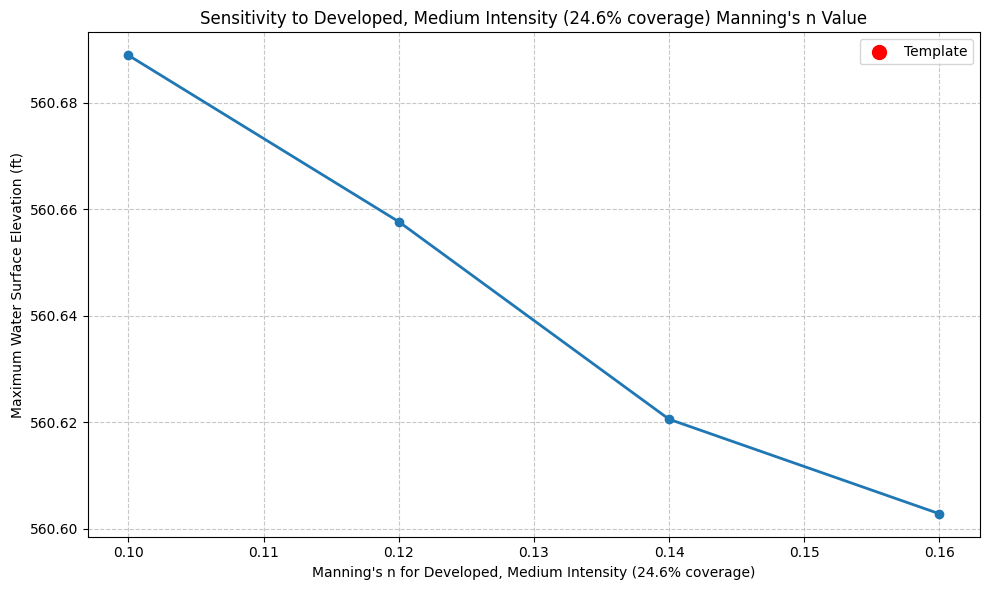

Created sensitivity plot for Developed, Medium Intensity


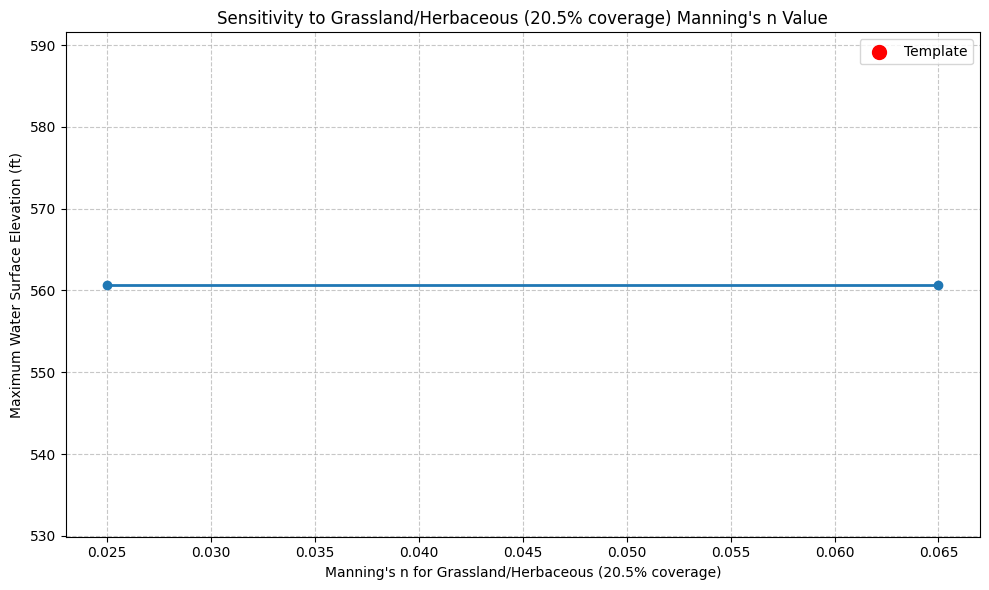

Created sensitivity plot for Grassland/Herbaceous


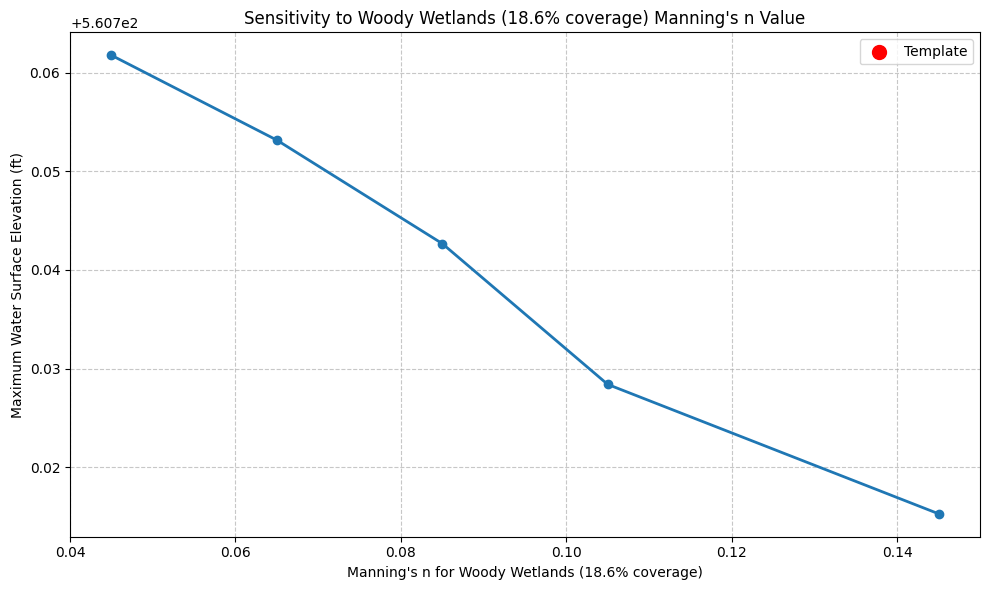

Created sensitivity plot for Woody Wetlands


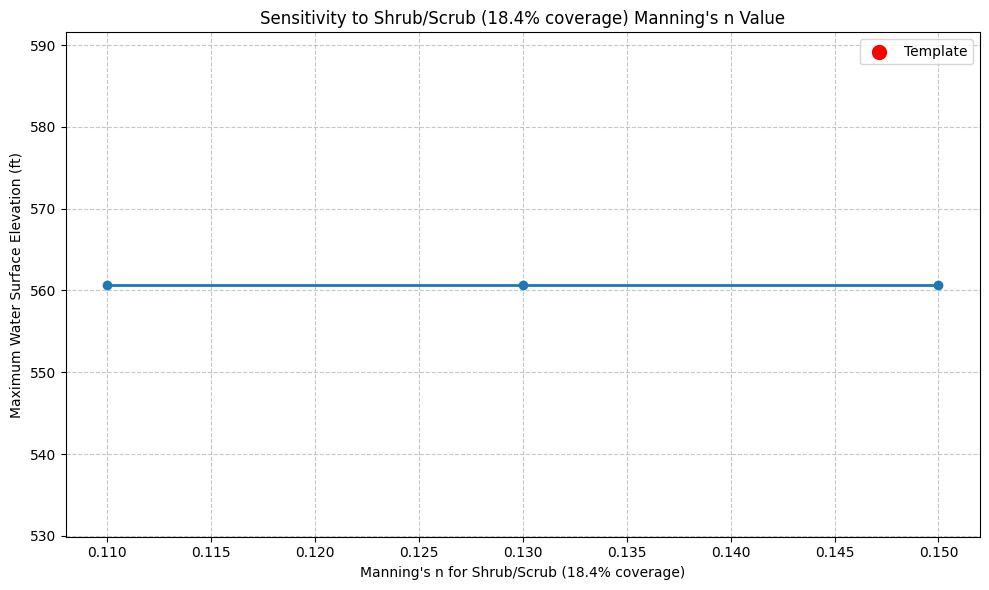

Created sensitivity plot for Shrub/Scrub


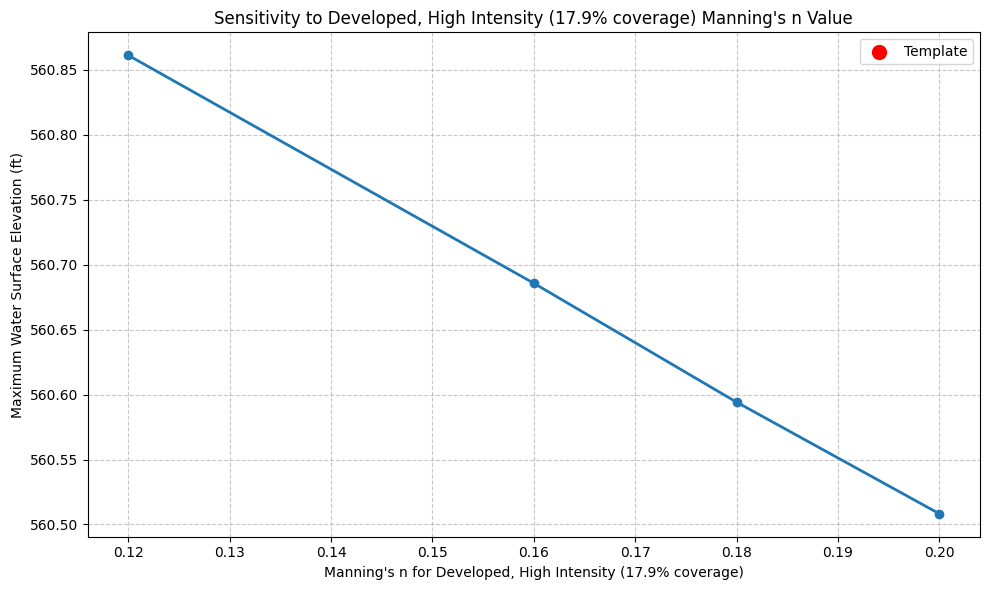

Created sensitivity plot for Developed, High Intensity


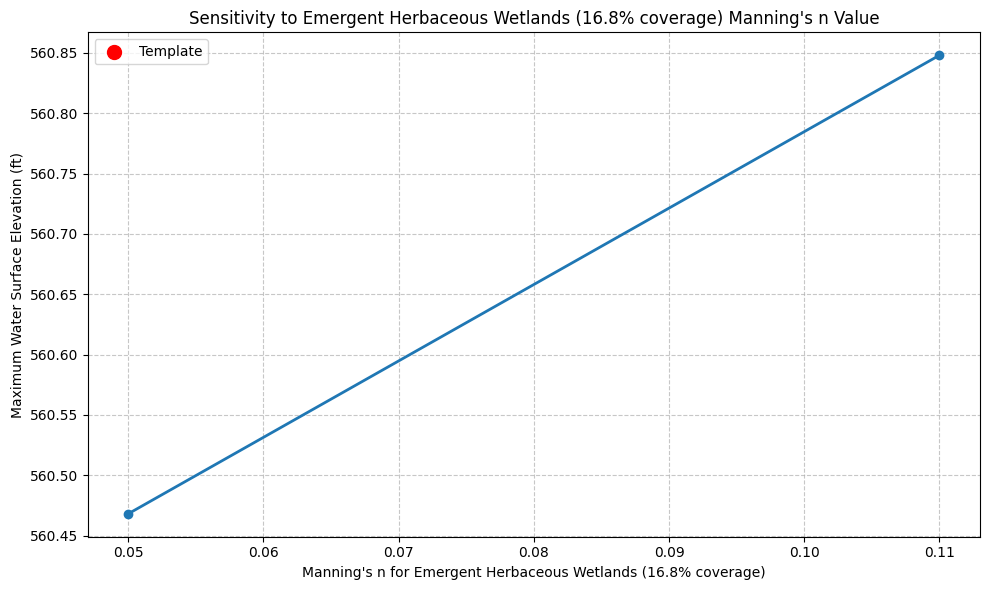

Created sensitivity plot for Emergent Herbaceous Wetlands


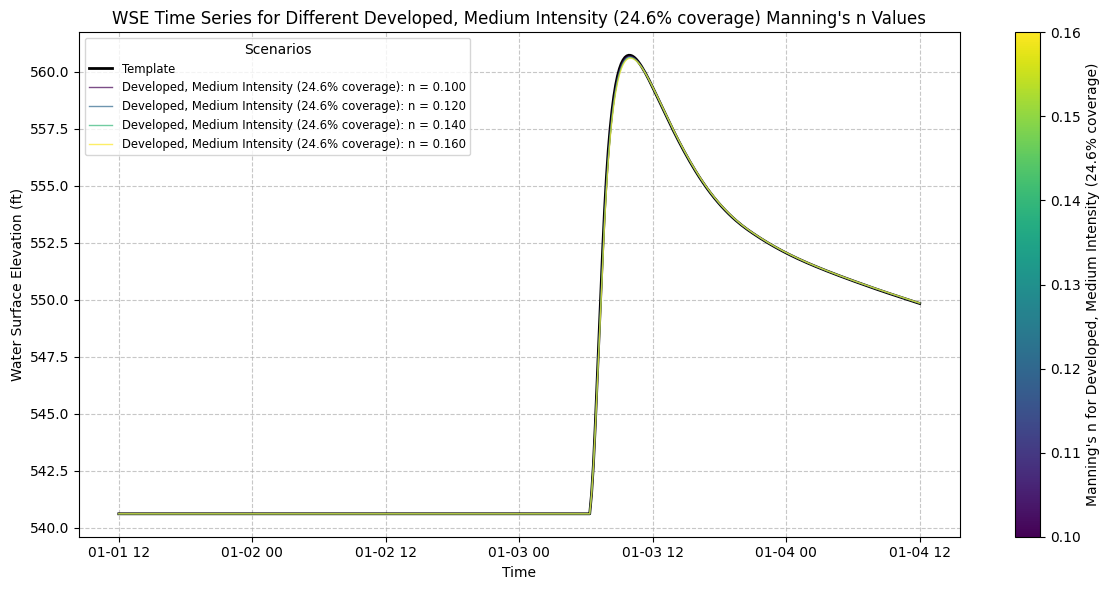

Created time series plot for Developed, Medium Intensity


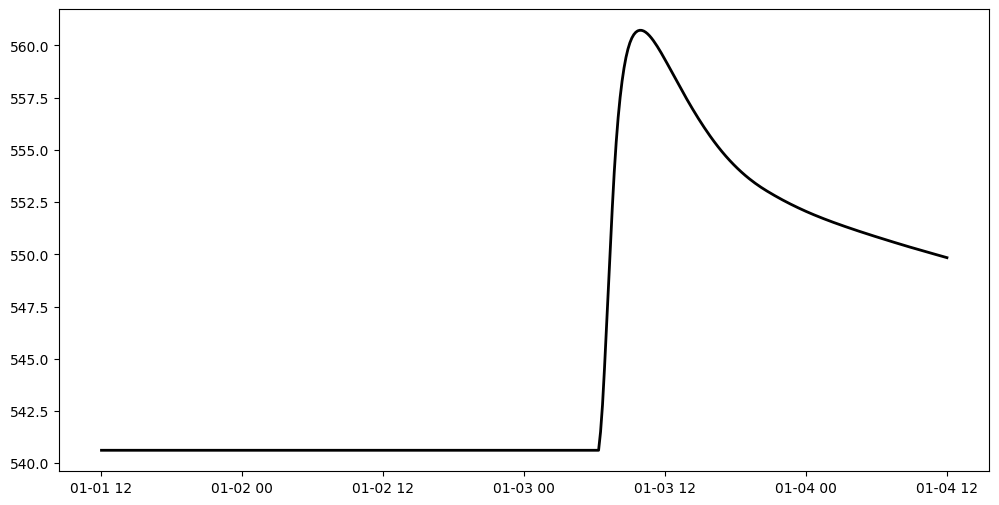

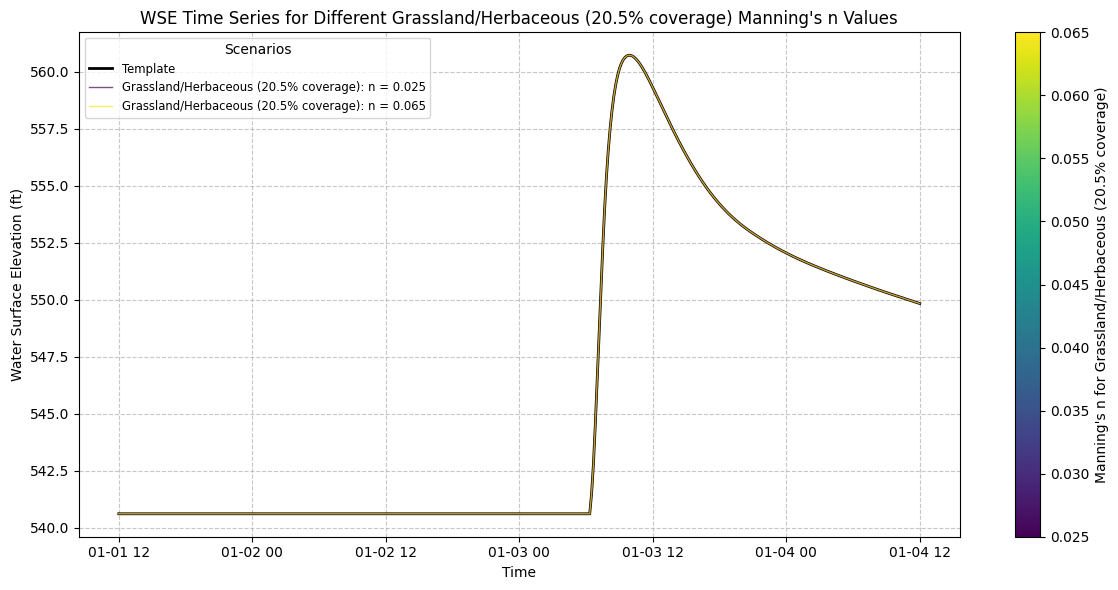

Created time series plot for Grassland/Herbaceous


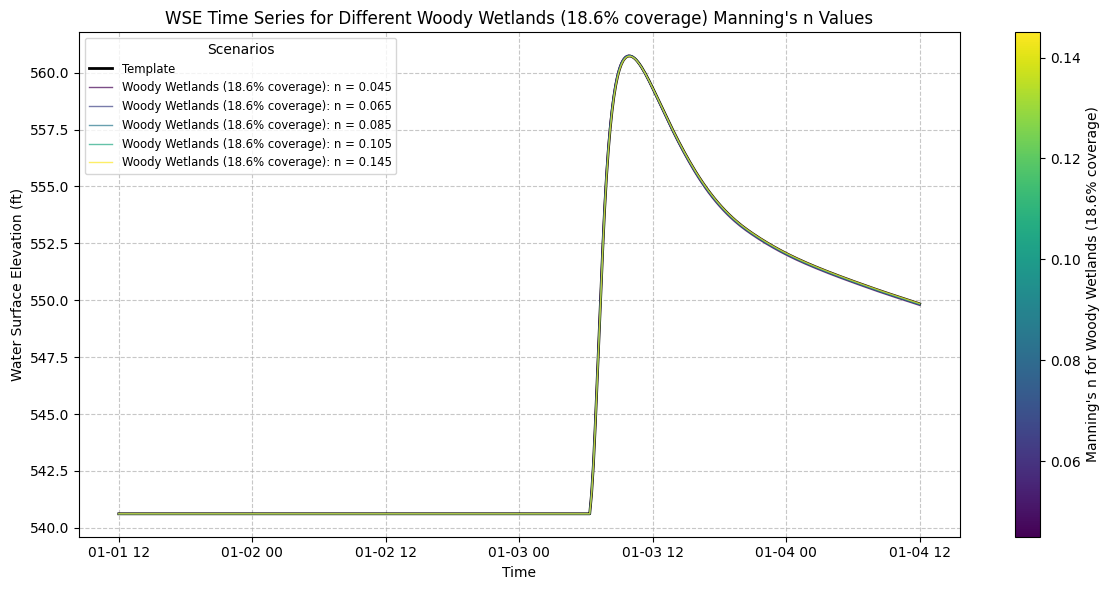

Created time series plot for Woody Wetlands


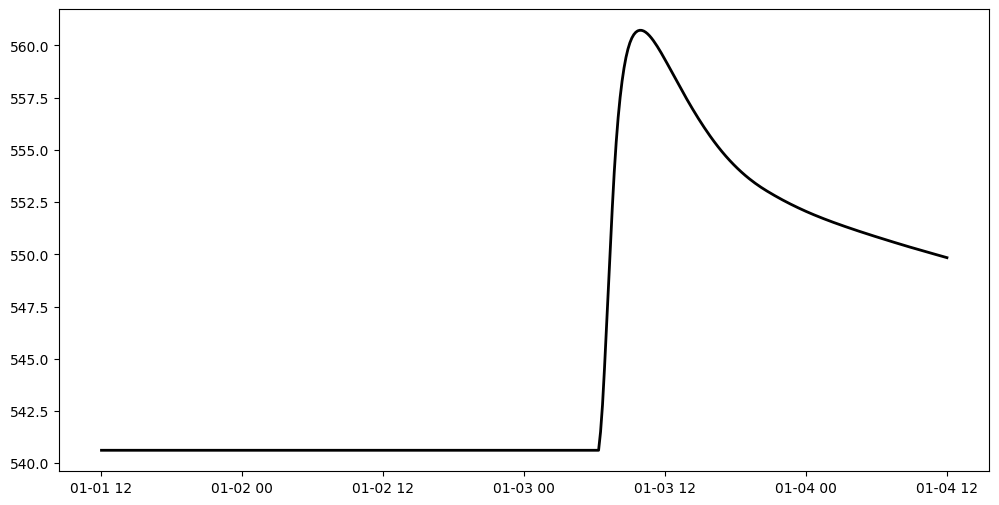

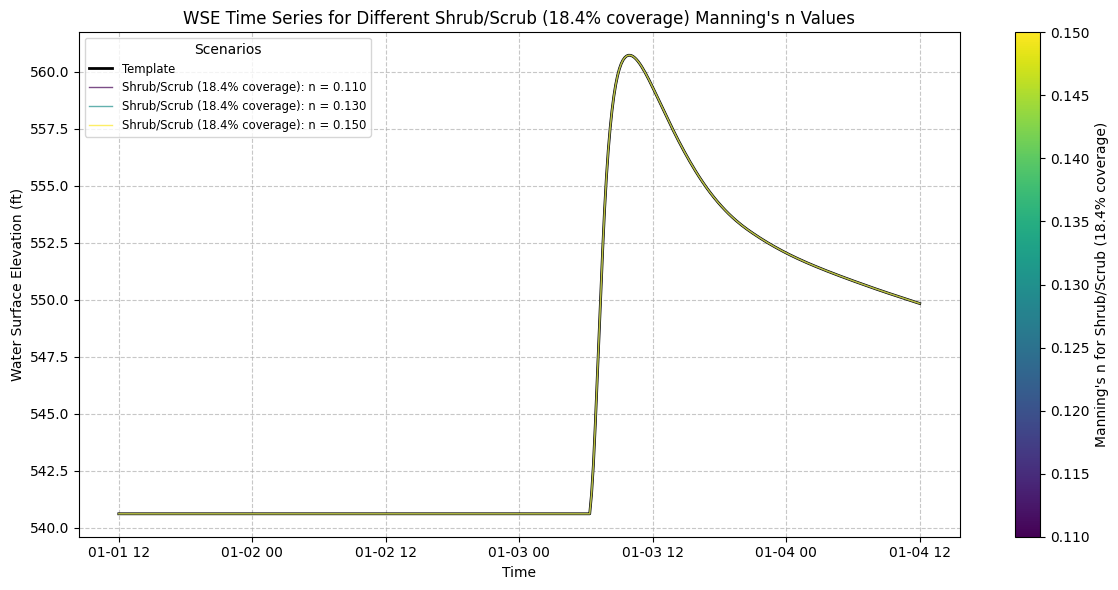

Created time series plot for Shrub/Scrub


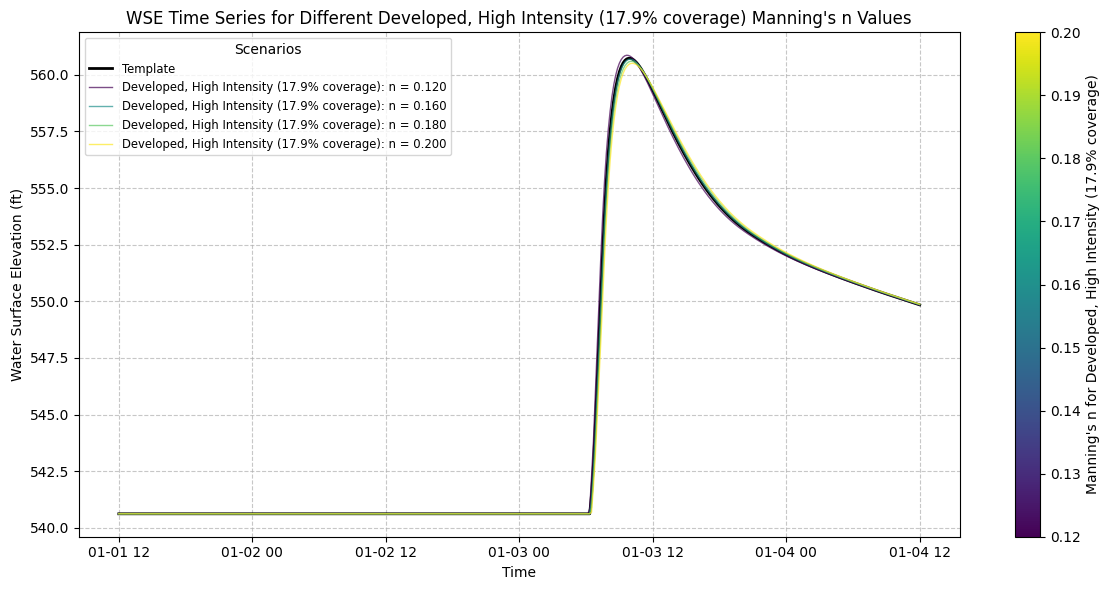

Created time series plot for Developed, High Intensity


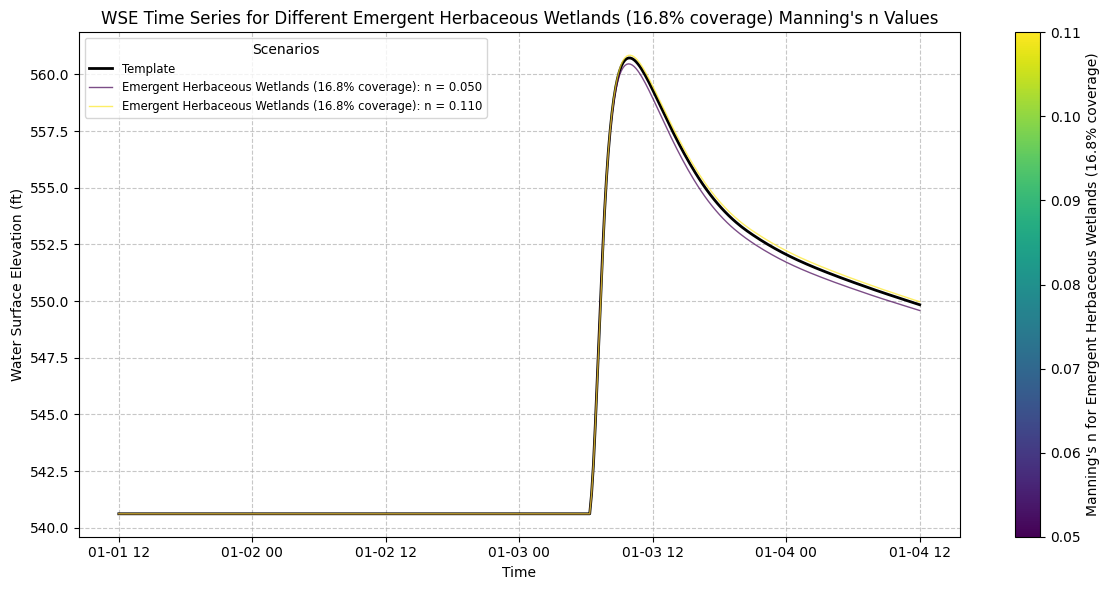

Created time series plot for Emergent Herbaceous Wetlands

Analysis complete! Results saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_BOMIS\Base_Landuse_Sensitivity

Significant land uses analyzed:
                Land Cover Type  Percentage
0   Developed, Medium Intensity   24.630900
1                        NoData   22.749712
2          Grassland/Herbaceous   20.516389
3                Woody Wetlands   18.570300
4                    Open Water   18.546225
5                   Shrub/Scrub   18.425513
6     Developed, High Intensity   17.887623
7  Emergent Herbaceous Wetlands   16.761743


In [12]:

# Run the base sensitivity analysis
base_sensitivity_results = individual_landuse_sensitivity_base(
    project_folder=project_folder,
    template_plan=template_plan,
    point_of_interest=point_of_interest,
    area_threshold=15.0,  # Only analyze land uses covering at least 10% of the mesh area
    interval=0.02,       # Adjust interval to reduce the number of test values
    max_workers=4,
    num_cores=NUM_CORES,
    output_folder="Base_Landuse_Sensitivity",
    n_ranges=manning_minmax_df
)



# Print summary information
if base_sensitivity_results:
    print("\nAnalysis complete! Results saved to:", base_sensitivity_results['output_folder'])
    if 'significant_landuses' in base_sensitivity_results:
        print("\nSignificant land uses analyzed:")
        print(base_sensitivity_results['significant_landuses'][['Land Cover Type', 'Percentage']])



-----

## Base Override Sensitivity Results

### Interpreting the Results

The following plots show sensitivity analysis results from the BaldEagleCrkMulti2D example project (Plan 03):

**Sensitivity Plots (Right):**
- Show how maximum water surface elevation varies with Manning's n
- X-axis: Manning's n value for the specific land cover type
- Y-axis: Maximum water surface elevation at the point of interest
- Red dot: Current/template Manning's n value
- Steeper slopes indicate higher sensitivity to that parameter

**Time Series Plots (Left):**
- Show complete hydrographs for all Manning's n scenarios
- Color gradient represents different Manning's n values
- Black line: Template (original) scenario
- Useful for understanding how timing and peak magnitude respond to parameter changes

**Key Observations to Look For:**
- Which land covers cause the largest changes in water surface elevation?
- Are the responses linear or non-linear?
- Does increasing roughness always increase water levels (as expected)?
- Are there threshold effects or inflection points?


-----

# Part 3: Regional Override Sensitivity Analysis

## Overview

Regional override sensitivity analysis focuses on Manning's n variations within specific calibration regions of the model. This approach is appropriate when:
- Calibrating main channel roughness separately from floodplain
- Analyzing the impact of localized land cover changes
- Testing region-specific parameter uncertainty
- Evaluating different roughness values in distinct hydraulic zones

**Key Differences from Base Sensitivity:**
- Tests only land covers present in the specified region(s)
- Can target a single region or analyze all regions
- Useful for main channel calibration or localized sensitivity testing
- Regional overrides take precedence over base mesh values in HEC-RAS

## Function: individual_landuse_sensitivity_region()

This function performs the complete regional override sensitivity workflow with region-specific filtering.

In [13]:
def individual_landuse_sensitivity_region(
    project_folder,
    template_plan,
    point_of_interest,
    area_threshold=10.0,  # percentage threshold for significant land uses
    interval=0.01,
    max_workers=MAX_WORKERS,
    num_cores=NUM_CORES,
    region_name=None,  # optional specific region to analyze
    output_folder="Regional_Landuse_Sensitivity",
    n_ranges=None
):
    """
    Perform sensitivity analysis by varying individual land use Manning's n values
    in the regional overrides.
    
    Args:
        project_folder (str): Path to HEC-RAS project folder
        template_plan (str): Plan number to use as template
        point_of_interest (tuple or Point): Coordinates for extracting results
        area_threshold (float): Percentage threshold for significant land uses
        interval (float): Interval for Manning's n test values
        max_workers (int): Number of parallel workers
        num_cores (int): Number of cores per worker
        region_name (str): Optional specific region to analyze
        output_folder (str): Name of output folder
        n_ranges (pd.DataFrame): DataFrame containing min/max Manning's n values.
                                    Must contain columns: 'Land Cover Name', 'min_n', 'max_n'
    
    Returns:
        dict: Results of sensitivity analysis
    """
    import time
    from datetime import datetime
    
    # Convert point_of_interest to Point if not already
    if not isinstance(point_of_interest, Point):
        point_of_interest = Point(point_of_interest[0], point_of_interest[1])
    
    # Verify n_ranges is provided
    if n_ranges is None:
        raise ValueError("n_ranges DataFrame must be provided")
    
    # Create timestamp for unique run identifier
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Initialize RAS project
    print(f"Initializing HEC-RAS project: {project_folder}")
    ras = init_ras_project(project_folder, RAS_VERSION)
    
    # Create output directory
    results_dir = Path(project_folder) / output_folder
    results_dir.mkdir(exist_ok=True)
    print(f"Results will be saved to: {results_dir}")
    
    # Verify template plan exists
    if template_plan not in ras.plan_df['plan_number'].values:
        raise ValueError(f"Template plan {template_plan} not found in project")
    
    # Get the geometry number for the template plan
    template_geom = ras.plan_df.loc[ras.plan_df['plan_number'] == template_plan, 'geometry_number'].values[0]
    print(f"\nTemplate plan: {template_plan} (Geometry: {template_geom})")
    
    # Get the geometry file path
    geom_path = ras.geom_df.loc[ras.geom_df['geom_number'] == template_geom, 'full_path'].values[0]
    
    # Get the original Manning's values
    original_baseoverrides = RasGeo.get_mannings_baseoverrides(geom_path)
    original_regionoverrides = RasGeo.get_mannings_regionoverrides(geom_path)
    
    # Check if regional overrides exist
    if original_regionoverrides.empty:
        print("No regional Manning's overrides found in the model")
        return None
    
    # If a specific region name is provided, filter the regional overrides
    if region_name is not None:
        region_mask = original_regionoverrides['Region Name'] == region_name
        if not region_mask.any():
            print(f"Region '{region_name}' not found in the model")
            available_regions = original_regionoverrides['Region Name'].unique()
            print(f"Available regions: {available_regions}")
            return None
        
        region_overrides = original_regionoverrides[region_mask].copy()
        print(f"\nAnalyzing sensitivity for region: {region_name}")
    else:
        region_overrides = original_regionoverrides.copy()
        print("\nAnalyzing sensitivity for all regions")
    
    # Get unique region tables
    region_tables = region_overrides['Table Number'].unique()
    print(f"Region tables: {region_tables}")
    
    # Analyze land cover statistics for the 2D mesh areas
    print("\nAnalyzing land cover statistics for the 2D mesh areas...")
    landcover_stats = analyze_mesh_land_cover_statistics(
        project_folder, 
        geom_number=template_geom
    )
    
    if landcover_stats is None:
        raise ValueError("Could not analyze land cover statistics")
    
    # Identify significant land uses (above threshold)
    significant_landuses = landcover_stats[landcover_stats['Percentage'] >= area_threshold].copy()
    significant_landuses = significant_landuses.sort_values('Percentage', ascending=False).reset_index(drop=True)
    
    if len(significant_landuses) == 0:
        print(f"No land uses found with coverage above {area_threshold}% threshold")
        return None
    
    print(f"\nFound {len(significant_landuses)} significant land uses (>= {area_threshold}% coverage):")
    print(significant_landuses[['Land Cover Type', 'Percentage', 'Current_n']])
    
    # Filter significant land uses to only those present in the region overrides
    region_landcover_types = set(region_overrides['Land Cover Name'].unique())
    filtered_landuses = significant_landuses[
        significant_landuses['Land Cover Type'].isin(region_landcover_types)
    ].copy()
    
    if len(filtered_landuses) == 0:
        print("None of the significant land uses are present in the regional overrides")
        return None
    
    print(f"\nSignificant land uses present in regional overrides:")
    print(filtered_landuses[['Land Cover Type', 'Percentage']])
    
    # Check if we'll exceed the plan limit
    current_plan_count = len(ras.plan_df)
    max_plans = 99  # HEC-RAS limit
    remaining_plans = max_plans - current_plan_count
    
    # Estimate the number of plans needed
    estimated_plan_count = 0
    
    # Create a table to store land use sensitivity information
    sensitivity_table = []
    
    for _, landuse in filtered_landuses.iterrows():
        land_cover = landuse['Land Cover Type']
        
        # Find this land cover in the region overrides
        for region_table in region_tables:
            # Create mask for this land cover and table
            mask = (region_overrides['Land Cover Name'] == land_cover) & \
                   (region_overrides['Table Number'] == region_table)
            
            if not mask.any():
                continue
                
            current_n = region_overrides.loc[mask, 'MainChannel'].values[0]
            
            # Find matching land cover in n_ranges
            match = n_ranges[n_ranges['Land Cover Name'] == land_cover]
            if match.empty:
                continue
                
            min_n = match['min_n'].values[0]
            max_n = match['max_n'].values[0]
            
            # Count values between min and max at interval spacing, excluding current value
            values = generate_sensitivity_values(min_n, max_n, current_n, interval)
            num_values = len(values)
            estimated_plan_count += num_values
            
            # Add to sensitivity table
            region_name = region_overrides.loc[mask, 'Region Name'].values[0] if 'Region Name' in region_overrides.columns else f"Table {region_table}"
            sensitivity_table.append({
                'Land Cover': land_cover,
                'Region': region_name,
                'Table': region_table,
                'Current n': current_n,
                'Min n': min_n,
                'Max n': max_n,
                'Test Values': num_values,
                'n Range': f"{min_n:.3f} - {max_n:.3f}"
            })
    
    # Print the sensitivity analysis table
    if sensitivity_table:
        print("\nSensitivity Analysis Plan:")
        print("-" * 80)
        print(f"{'Land Cover':<20} {'Region':<15} {'Current n':<10} {'n Range':<15} {'Test Values':<12}")
        print("-" * 80)
        for row in sensitivity_table:
            print(f"{row['Land Cover']:<20} {row['Region']:<15} {row['Current n']:<10.3f} {row['n Range']:<15} {row['Test Values']:<12}")
        print("-" * 80)
        print(f"Total estimated plans to be created: {estimated_plan_count}")
        print("-" * 80)
    if estimated_plan_count > remaining_plans:
        print(f"\nWARNING: This analysis would create approximately {estimated_plan_count} plans, but only {remaining_plans} more plans can be added (limit is 99)")
        print("Consider adjusting the following to reduce the number of plans:")
        print(f"1. Increase the area threshold (currently {area_threshold}%)")
        print(f"2. Increase the interval between test values (currently {interval})")
        print(f"3. Reduce the min/max ranges for land uses")
        print(f"4. Select fewer land uses to test")
        print(f"5. Specify a single region to test (currently {'specific region' if region_name else 'all regions'})")
        
        # Ask for confirmation to continue
        response = input("\nDo you want to continue anyway? (y/n): ")
        if response.lower() != 'y':
            print("Analysis canceled")
            return None
    
    # Store the current (template) plan as base scenario
    scenarios = [{
        'name': 'Template',
        'plan_number': template_plan,
        'geom_number': template_geom,
        'shortid': 'Template',
        'land_cover': None,
        'region_name': None,
        'table_number': None,
        'n_value': None,
        'description': "Original Manning's n Values"
    }]
    
    # Function to create a modified plan with adjusted Manning's n values for a specific land use in a region
    def create_modified_plan(land_cover, table_number, region_name, new_n_value):
        # Create a shortid based on land cover, region, and n value
        # Convert land cover name to code (e.g. "Open Water" -> "OW")
        lc_code = ''.join([word[0] for word in land_cover.split() if word[0].isalpha()])
        if not lc_code:
            lc_code = land_cover[:2]
        lc_code = lc_code.upper()
        
        # Convert region name to code
        rg_code = ''.join([word[0] for word in region_name.split() if word[0].isalpha()])
        if not rg_code:
            rg_code = region_name[:2]
        rg_code = rg_code.upper()
        
        # Format n value for shortid
        n_str = f"{new_n_value:.3f}".replace(".", "")
        shortid = f"R_{lc_code}_{rg_code}_{n_str}"
        
        print(f"\nCreating plan for '{land_cover}' in '{region_name}' with n = {new_n_value} (ShortID: {shortid})")
        
        # Clone the template plan
        new_plan_number = RasPlan.clone_plan(template_plan, new_plan_shortid=shortid)
        
        # Clone the template geometry
        new_geom_number = RasPlan.clone_geom(template_geom)
        
        # Set the new plan to use the new geometry
        RasPlan.set_geom(new_plan_number, new_geom_number)
        
        # Get the new geometry file path
        new_geom_path = ras.geom_df.loc[ras.geom_df['geom_number'] == new_geom_number, 'full_path'].values[0]
        
        # Copy base overrides unchanged
        RasGeo.set_mannings_baseoverrides(new_geom_path, original_baseoverrides)
        
        # Create modified region overrides
        modified_regionoverrides = original_regionoverrides.copy()
        
        # Update the Manning's n value for this specific land cover type in this region and table
        region_mask = (modified_regionoverrides['Land Cover Name'] == land_cover) & \
                     (modified_regionoverrides['Table Number'] == table_number) & \
                     (modified_regionoverrides['Region Name'] == region_name)
                     
        if region_mask.any():
            current_n = modified_regionoverrides.loc[region_mask, 'MainChannel'].values[0]
            print(f"  Changing '{land_cover}' in '{region_name}' (Table {table_number}) from {current_n:.4f} to {new_n_value:.4f}")
            modified_regionoverrides.loc[region_mask, 'MainChannel'] = new_n_value
        else:
            print(f"  Warning: Land cover '{land_cover}' not found in region '{region_name}' (Table {table_number})")
        
        # Apply the modified region overrides
        RasGeo.set_mannings_regionoverrides(new_geom_path, modified_regionoverrides)
        
        # Store scenario details
        return {
            'name': f"{land_cover}_{region_name}_{new_n_value:.3f}",
            'plan_number': new_plan_number,
            'geom_number': new_geom_number,
            'shortid': shortid,
            'land_cover': land_cover,
            'region_name': region_name,
            'table_number': table_number,
            'n_value': new_n_value,
            'description': f"Manning's n = {new_n_value:.3f} for {land_cover} in {region_name}"
        }
    
    # Create plans for each significant land use with varying n values
    all_plans_to_run = []
    
    for _, landuse in filtered_landuses.iterrows():
        land_cover = landuse['Land Cover Type']
        
        # Find matching land cover in n_ranges
        match = n_ranges[n_ranges['Land Cover Name'] == land_cover]
        
        if match.empty:
            print(f"Warning: No Manning's n range found for '{land_cover}'. Skipping.")
            continue
            
        min_n = match['min_n'].values[0]
        max_n = match['max_n'].values[0]
        
        # Process each region table for this land cover
        for region_table in region_tables:
            # Get all regions with this land cover in this table
            regions_mask = (region_overrides['Land Cover Name'] == land_cover) & \
                          (region_overrides['Table Number'] == region_table)
            
            if not regions_mask.any():
                continue
            
            # Get unique region names for this land cover and table
            unique_regions = region_overrides.loc[regions_mask, 'Region Name'].unique()
            
            for region in unique_regions:
                # If a specific region was requested, skip others
                if region_name is not None and region != region_name:
                    continue
                
                # Create mask for this specific combination
                specific_mask = (region_overrides['Land Cover Name'] == land_cover) & \
                               (region_overrides['Table Number'] == region_table) & \
                               (region_overrides['Region Name'] == region)
                
                if not specific_mask.any():
                    continue
                
                current_n = region_overrides.loc[specific_mask, 'MainChannel'].values[0]
                
                print(f"\nProcessing land cover: {land_cover} in region: {region} (Table {region_table})")
                print(f"  Current n: {current_n:.4f}")
                print(f"  Literature range: {min_n:.4f} to {max_n:.4f}")
                
                # Generate test values within the range, excluding the current value
                test_values = generate_sensitivity_values(min_n, max_n, current_n, interval)
                
                print(f"  Testing {len(test_values)} values: {[round(val, 3) for val in test_values]}")
                
                # Create a plan for each test value
                for n_value in test_values:
                    new_scenario = create_modified_plan(land_cover, region_table, region, n_value)
                    scenarios.append(new_scenario)
                    all_plans_to_run.append(new_scenario['plan_number'])
    
    # Save scenario information
    scenario_info = pd.DataFrame(scenarios)
    scenario_info_path = results_dir / "scenarios.csv"
    scenario_info.to_csv(scenario_info_path, index=False)
    print(f"\nScenario information saved to: {scenario_info_path}")
    
    # Run the plans (excluding the template which is already computed)
    plans_to_run = [plan for plan in all_plans_to_run if plan != template_plan]
    
    if not plans_to_run:
        print("No plans to run.")
        return {'scenarios': scenarios, 'output_folder': results_dir}
    
    print(f"\nRunning {len(plans_to_run)} plans in parallel...")
    execution_results = RasCmdr.compute_parallel(
        plan_number=plans_to_run,
        max_workers=max_workers,
        num_cores=num_cores,
        clear_geompre=True
    )
    
    print("\nExecution results:")
    for plan, success in execution_results.items():
        print(f"  Plan {plan}: {'Successful' if success else 'Failed'}")
    
    # If point of interest provided, extract and compare results
    if point_of_interest is not None:
        # Get geometry HDF path for cell identification
        geom_hdf_path = ras.geom_df.loc[ras.geom_df['geom_number'] == template_geom, 'hdf_path'].values[0]
        
        # Find the nearest mesh cell
        mesh_cells_gdf = HdfMesh.get_mesh_cell_points(geom_hdf_path)
        distances = mesh_cells_gdf.geometry.apply(lambda geom: geom.distance(point_of_interest))
        nearest_idx = distances.idxmin()
        mesh_cell_id = mesh_cells_gdf.loc[nearest_idx, 'cell_id']
        mesh_name = mesh_cells_gdf.loc[nearest_idx, 'mesh_name']
        
        print(f"\nNearest cell ID: {mesh_cell_id}")
        print(f"Distance: {distances[nearest_idx]:.2f} units")
        print(f"Mesh area: {mesh_name}")
        
        # Extract results for each scenario
        all_results = {}
        max_ws_values = []
        
        for scenario in scenarios:
            plan_number = scenario['plan_number']
            land_cover = scenario['land_cover']
            region_name = scenario['region_name']
            n_value = scenario['n_value']
            shortid = scenario['shortid']
            
            try:
                results_xr = HdfResultsMesh.get_mesh_cells_timeseries(plan_number, ras_object=ras)
                
                # Extract water surface data
                ws_data = results_xr[mesh_name]['Water Surface'].sel(cell_id=int(mesh_cell_id))
                
                # Convert to DataFrame
                ws_df = pd.DataFrame({
                    'time': ws_data.time.values,
                    'water_surface': ws_data.values
                })
                
                # Store results
                max_ws = ws_df['water_surface'].max()
                
                all_results[plan_number] = {
                    'scenario': scenario,
                    'df': ws_df,
                    'max_water_surface': max_ws
                }
                
                max_ws_values.append({
                    'plan_number': plan_number,
                    'shortid': shortid,
                    'land_cover': land_cover,
                    'region_name': region_name,
                    'n_value': n_value,
                    'max_water_surface': max_ws
                })
                
                print(f"  {shortid}: Max WSE = {max_ws:.2f}")
                
                # Save time series to CSV
                ws_df.to_csv(results_dir / f"timeseries_{shortid}.csv", index=False)
                
            except Exception as e:
                print(f"  Error extracting results for {shortid}: {str(e)}")
        
        # Create summary DataFrame
        if max_ws_values:
            max_ws_df = pd.DataFrame(max_ws_values)
            max_ws_df.to_csv(results_dir / "max_water_surface_summary.csv", index=False)
            
            # Create plots by land cover type and region
            land_cover_region_combinations = []
            
            for _, row in max_ws_df.iterrows():
                if row['land_cover'] is not None and row['region_name'] is not None:
                    combination = (row['land_cover'], row['region_name'])
                    if combination not in land_cover_region_combinations:
                        land_cover_region_combinations.append(combination)
            
            # Create sensitivity plots for each land cover + region combination
            for land_cover, region in land_cover_region_combinations:
                # Filter scenarios for this combination
                combo_scenarios = max_ws_df[
                    (max_ws_df['land_cover'] == land_cover) & 
                    (max_ws_df['region_name'] == region)
                ].copy()
                
                # Add the template scenario
                template_row = max_ws_df[max_ws_df['shortid'] == 'Template']
                if not template_row.empty:
                    combo_scenarios = pd.concat([template_row, combo_scenarios])
                
                if combo_scenarios.empty:
                    continue

                valid_points = combo_scenarios['n_value'].notna().sum()
                if valid_points <= 1:
                    continue
                
                # Sort by n_value
                combo_scenarios = combo_scenarios.sort_values('n_value').reset_index(drop=True)
                
                # Create plot
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.plot(combo_scenarios['n_value'], combo_scenarios['max_water_surface'], 
                         marker='o', linestyle='-', linewidth=2)
                
                # Add template point in a different color if it exists
                template_idx = combo_scenarios[combo_scenarios['shortid'] == 'Template'].index
                if not template_idx.empty:
                    ax.scatter(combo_scenarios.loc[template_idx, 'n_value'], 
                                combo_scenarios.loc[template_idx, 'max_water_surface'],
                                color='red', s=100, zorder=5, label='Template')
                
                # Add labels and title
                ax.set_xlabel(f"Manning's n for {land_cover} in {region}")
                ax.set_ylabel("Maximum Water Surface Elevation (ft)")
                ax.set_title(f"Sensitivity to {land_cover} Manning's n Value in {region}")
                ax.grid(True, linestyle='--', alpha=0.7)
                
                if not template_idx.empty:
                    ax.legend()
                
                # Save plot
                safe_lc = land_cover.replace(' ', '_').replace('/', '_')
                safe_rg = region.replace(' ', '_').replace('/', '_')
                plot_path = results_dir / f"sensitivity_{safe_lc}_{safe_rg}.png"
                plt.tight_layout()
                plt.savefig(plot_path)
                plt.show()
                plt.close()
                print(f"Created sensitivity plot for {land_cover} in {region}")
            
            # Create time series comparison plots for each land cover + region combination
            for land_cover, region in land_cover_region_combinations:
                fig, ax = plt.subplots(figsize=(12, 6))
                
                # Get template results
                template_plan = scenarios[0]['plan_number']
                if template_plan in all_results:
                    template_df = all_results[template_plan]['df']
                    ax.plot(template_df['time'], template_df['water_surface'], 
                             color='black', linewidth=2, label='Template')
                
                # Filter scenarios for this combination
                combo_scenarios = [
                    s for s in scenarios 
                    if s['land_cover'] == land_cover and s['region_name'] == region
                ]
                
                if not combo_scenarios:
                    plt.show()
                    plt.close()
                    continue
                
                # Setup colormap for n values
                n_values = [s['n_value'] for s in combo_scenarios if s['n_value'] is not None]
                if not n_values:
                    plt.show()
                    plt.close()
                    continue
                
                if len(n_values) <= 1:
                    plt.show()
                    plt.close()
                    continue
                    
                min_n = min(n_values)
                max_n = max(n_values)
                norm = plt.Normalize(min_n, max_n)
                cmap = plt.cm.viridis
                
                # Plot each scenario
                for scenario in combo_scenarios:
                    plan_number = scenario['plan_number']
                    n_value = scenario['n_value']
                    
                    if plan_number in all_results and n_value is not None:
                        df = all_results[plan_number]['df']
                        color = cmap(norm(n_value))
                        ax.plot(df['time'], df['water_surface'], color=color, 
                                 linewidth=1, alpha=0.7, label=f"n = {n_value:.3f}")
                
                # Add labels and title
                ax.set_xlabel("Time")
                ax.set_ylabel("Water Surface Elevation (ft)")
                ax.set_title(f"WSE Time Series for {land_cover} in {region}")
                ax.grid(True, linestyle='--', alpha=0.7)
                
                # Add colorbar
                sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
                sm.set_array([])
                cbar = plt.colorbar(sm, ax=ax)
                cbar.set_label(f"Manning's n for {land_cover}")
                
                # Save plot
                safe_lc = land_cover.replace(' ', '_').replace('/', '_')
                safe_rg = region.replace(' ', '_').replace('/', '_')
                plot_path = results_dir / f"timeseries_{safe_lc}_{safe_rg}.png"
                plt.tight_layout()
                plt.savefig(plot_path)
                plt.show()
                plt.close()
                print(f"Created time series plot for {land_cover} in {region}")
    
    # Return results
    return {
        'scenarios': scenarios,
        'execution_results': execution_results if 'execution_results' in locals() else None,
        'results': all_results if 'all_results' in locals() else None,
        'max_ws_summary': max_ws_df if 'max_ws_df' in locals() else None,
        'significant_landuses': filtered_landuses,
        'output_folder': results_dir
    }

-----

-----

## ⚠️ Important Engineering Note on Regional Overrides

We are using a HEC Example project with regional overriddes in the main channel.  A better application would be to vary values individually within larger calibration regions.  A further explanation follows: 

**Main Channel vs. Floodplain Application:**

For **main channel** regional overrides, a **bulk sensitivity approach** is typically more appropriate (see notebook 105 for bulk Manning's n variation). This is because:

1. **Land use-based roughness** values are derived from satellite imagery, which may not correlate well with main channel hydraulic roughness
2. **Main channel roughness** is typically governed by bed material, channel shape, and vegetation conditions—not upland land cover classifications
3. **Bulk variation** allows testing a continuous range of main channel n values without land use constraints

**This Methodology Best Applied To:**
- Large calibration regions within the 2D mesh area
- Floodplain zones with distinct land cover characteristics
- Areas where satellite-derived land use correlates with hydraulic roughness

**For Main Channel Calibration:**
- Use the bulk sensitivity approach from notebook 105
- Create multiple regional overrides to test different main channel reaches independently
- Consider physical channel characteristics rather than land cover when selecting test values

**Note on Example Project:**
This notebook demonstrates the regional sensitivity methodology using the BaldEagleCrkMulti2D main channel region due to limited availability of example models with large floodplain calibration regions. In practice, apply this approach to appropriate floodplain or mesh regions where land cover-based roughness is hydraulically meaningful.

## Executing Regional Override Sensitivity Analysis

### Configuration Parameters

The following example demonstrates how to run the regional override sensitivity analysis with the BaldEagleCrkMulti2D sample project.

**Key Parameters (in addition to base parameters):**
- `region_name`: Specific region to analyze (e.g., "Main Channel"), or `None` to analyze all regions
- All other parameters match the base sensitivity function

**Region-Specific Behavior:**
- Only land covers present in the specified region(s) will be tested
- The function automatically filters significant land uses based on region membership
- Multiple regions with the same land cover will be tested independently

### Execution Steps

1. Use the same project from the base analysis (already extracted)
2. Configure regional analysis parameters (note the `region_name` parameter)
3. Run the sensitivity analysis
4. Review region-specific results in the output folder


In [14]:
# Reuse Manning's n ranges from the base section

print(f"Manning's n value ranges for {len(manning_minmax_df)} land cover types:")
print(manning_minmax_df)

Manning's n value ranges for 16 land cover types:
                 Land Cover Name  min_n  max_n   mid_n
0     Barren Land Rock/Sand/Clay  0.023   0.10  0.0615
1               Cultivated Crops  0.020   0.10  0.0600
2               Deciduous Forest  0.100   0.20  0.1500
3      Developed, High Intensity  0.120   0.20  0.1600
4       Developed, Low Intensity  0.060   0.12  0.0900
5    Developed, Medium Intensity  0.080   0.16  0.1200
6          Developed, Open Space  0.030   0.09  0.0600
7   Emergent Herbaceous Wetlands  0.050   0.12  0.0850
8               Evergreen Forest  0.080   0.16  0.1200
9           Grassland/Herbaceous  0.025   0.07  0.0475
10                  Mixed Forest  0.080   0.20  0.1400
11                        NoData  0.050   0.07  0.0600
12                    Open Water  0.025   0.05  0.0375
13                   Pasture/Hay  0.025   0.09  0.0575
14                   Shrub/Scrub  0.070   0.16  0.1150
15                Woody Wetlands  0.045   0.15  0.0975


2026-01-19 14:11:41 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-19 14:11:41 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D' as 'BaldEagleCrkMulti2D_106'
2026-01-19 14:11:41 - ras_commander.RasExamples - INFO - Folder 'BaldEagleCrkMulti2D_106' already exists. Deleting existing folder...
2026-01-19 14:11:41 - ras_commander.RasExamples - INFO - Existing folder 'BaldEagleCrkMulti2D_106' has been deleted.
2026-01-19 14:11:43 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_106


Creating dedicated ROMIS project folder...


2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g06
2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g06
2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g08
2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g08
2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g10


Created: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS


2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g10
2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g11
2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g12
2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12
2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

Executing template plan 03 before sensitivity analysis...


2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:11:44 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:11:44 - ras_commander.RasCmdr - INFO - Set number of cores to 2 for plan: 03
2026-01-19 14:11:44 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:
2026-01-19 14:11:44 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p03"
2026-01-19 14:14:40 - ras_commander.RasCmdr - INFO - HEC-RAS 

Template plan 03 execution complete.
Initializing HEC-RAS project: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS


2026-01-19 14:14:41 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:14:41 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:14:41 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:14:41 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2026-01-19 14:14:41 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p03.hdf
2026-01-19 14:14:41 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p03.hdf
2026-01-19 14:14:41 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from H

Results will be saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\Regional_Landuse_Sensitivity

Template plan: 03 (Geometry: 09)

Analyzing sensitivity for region: Main Channel
Region tables: ['16']

Analyzing land cover statistics for the 2D mesh areas...


2026-01-19 14:14:41 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:14:41 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:14:41 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:14:41 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:14:41 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:14:41 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2026-01-19 14:14:41 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p03.hdf
2026-01-19 14:14:41 - ras_commander.hdf.HdfResultsPlan - INFO -

Regional Manning's n overrides found - these areas will be excluded from base sensitivity analysis
Analyzing land cover for mesh area: BaldEagleCr

Found 11 significant land uses (>= 10.0% coverage):
                 Land Cover Type  Percentage  Current_n
0    Developed, Medium Intensity   24.630900      0.080
1                         NoData   22.749712      0.060
2           Grassland/Herbaceous   20.516389      0.045
3                 Woody Wetlands   18.570300      0.120
4                     Open Water   18.546225      0.035
5                    Shrub/Scrub   18.425513      0.080
6      Developed, High Intensity   17.887623      0.150
7   Emergent Herbaceous Wetlands   16.761743      0.080
8               Evergreen Forest   14.198315      0.120
9          Developed, Open Space   13.342006      0.040
10                  Mixed Forest   10.901125      0.080

Significant land uses present in regional overrides:
                 Land Cover Type  Percentage
0    Developed, Medium Intens

2026-01-19 14:14:41 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:14:41 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:14:41 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:14:41 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:14:41 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:14:41 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:14:41 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.rasmap
2026-01-19 14:14:41 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\B

  Changing 'Developed, Medium Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.0800

Creating plan for 'Developed, Medium Intensity' in 'Main Channel' with n = 0.12 (ShortID: R_DMI_MC_0120)


2026-01-19 14:14:42 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:14:42 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:14:42 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:14:42 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:14:42 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:14:42 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:14:42 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:14:42 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g04
2026-01-19 14:14:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\

  Changing 'Developed, Medium Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.1200

Creating plan for 'Developed, Medium Intensity' in 'Main Channel' with n = 0.16 (ShortID: R_DMI_MC_0160)


2026-01-19 14:14:43 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:14:43 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:14:43 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:14:43 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:14:43 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:14:43 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:14:43 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g04
2026-01-19 14:14:43 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g05
2026-01-19 14:14:43 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Developed, Medium Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.1600

Processing land cover: NoData in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0500 to 0.0700
  Testing 1 values: [np.float64(0.09)]

Creating plan for 'NoData' in 'Main Channel' with n = 0.09 (ShortID: R_N_MC_0090)


2026-01-19 14:14:45 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:14:45 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:14:45 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:14:45 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:14:45 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:14:45 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:14:45 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g04
2026-01-19 14:14:45 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g05
2026-01-19 14:14:45 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'NoData' in 'Main Channel' (Table 16) from 0.0400 to 0.0900

Processing land cover: Grassland/Herbaceous in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0250 to 0.0700
  Testing 1 values: [np.float64(0.065)]

Creating plan for 'Grassland/Herbaceous' in 'Main Channel' with n = 0.065 (ShortID: R_G_MC_0065)


2026-01-19 14:14:46 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:14:46 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:14:46 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:14:46 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:14:46 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:14:46 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:14:46 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:14:46 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g04
2026-01-19 14:14:46 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Grassland/Herbaceous' in 'Main Channel' (Table 16) from 0.0400 to 0.0650

Processing land cover: Woody Wetlands in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0450 to 0.1500
  Testing 3 values: [np.float64(0.085), np.float64(0.125), np.float64(0.165)]

Creating plan for 'Woody Wetlands' in 'Main Channel' with n = 0.085 (ShortID: R_WW_MC_0085)


2026-01-19 14:14:47 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 14:14:47 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:14:47 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:14:47 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:14:47 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:14:47 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:14:47 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:14:47 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:14:47 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Woody Wetlands' in 'Main Channel' (Table 16) from 0.0400 to 0.0850

Creating plan for 'Woody Wetlands' in 'Main Channel' with n = 0.125 (ShortID: R_WW_MC_0125)


2026-01-19 14:14:49 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 14:14:49 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 14:14:49 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:14:49 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:14:49 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:14:49 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:14:49 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:14:49 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:14:49 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Woody Wetlands' in 'Main Channel' (Table 16) from 0.0400 to 0.1250

Creating plan for 'Woody Wetlands' in 'Main Channel' with n = 0.165 (ShortID: R_WW_MC_0165)


2026-01-19 14:14:50 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:14:50 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:14:50 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:14:50 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:14:50 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:14:50 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:14:50 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g04
2026-01-19 14:14:50 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g05
2026-01-19 14:14:50 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Woody Wetlands' in 'Main Channel' (Table 16) from 0.0400 to 0.1650

Processing land cover: Open Water in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0250 to 0.0500
  Testing 1 values: [np.float64(0.065)]

Creating plan for 'Open Water' in 'Main Channel' with n = 0.065 (ShortID: R_OW_MC_0065)


2026-01-19 14:14:52 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:14:52 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:14:52 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:14:52 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:14:52 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:14:52 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:14:52 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g04
2026-01-19 14:14:52 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g05
2026-01-19 14:14:52 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Open Water' in 'Main Channel' (Table 16) from 0.0400 to 0.0650

Processing land cover: Shrub/Scrub in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0700 to 0.1600
  Testing 3 values: [np.float64(0.07), np.float64(0.11), np.float64(0.15)]

Creating plan for 'Shrub/Scrub' in 'Main Channel' with n = 0.07 (ShortID: R_S_MC_0070)


2026-01-19 14:14:53 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 14:14:53 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:14:53 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:14:53 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:14:53 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:14:53 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:14:53 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:14:53 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:14:53 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Shrub/Scrub' in 'Main Channel' (Table 16) from 0.0400 to 0.0700

Creating plan for 'Shrub/Scrub' in 'Main Channel' with n = 0.11 (ShortID: R_S_MC_0110)


2026-01-19 14:14:55 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 14:14:55 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 14:14:55 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:14:55 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:14:55 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:14:55 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:14:55 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:14:55 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:14:55 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Shrub/Scrub' in 'Main Channel' (Table 16) from 0.0400 to 0.1100

Creating plan for 'Shrub/Scrub' in 'Main Channel' with n = 0.15 (ShortID: R_S_MC_0150)


2026-01-19 14:14:57 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 14:14:57 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 14:14:57 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:14:57 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:14:57 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:14:57 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:14:57 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:14:57 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:14:57 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Shrub/Scrub' in 'Main Channel' (Table 16) from 0.0400 to 0.1500

Processing land cover: Developed, High Intensity in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.1200 to 0.2000
  Testing 3 values: [np.float64(0.12), np.float64(0.16), np.float64(0.2)]

Creating plan for 'Developed, High Intensity' in 'Main Channel' with n = 0.12 (ShortID: R_DHI_MC_0120)


2026-01-19 14:14:59 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:14:59 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:14:59 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:14:59 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:14:59 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:14:59 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:14:59 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:14:59 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g04
2026-01-19 14:14:59 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Developed, High Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.1200

Creating plan for 'Developed, High Intensity' in 'Main Channel' with n = 0.16 (ShortID: R_DHI_MC_0160)


2026-01-19 14:15:01 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:15:01 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:15:01 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:15:01 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:15:01 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:15:01 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:15:01 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:15:01 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g04
2026-01-19 14:15:01 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Developed, High Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.1600

Creating plan for 'Developed, High Intensity' in 'Main Channel' with n = 0.2 (ShortID: R_DHI_MC_0200)


2026-01-19 14:15:03 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:15:03 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:15:03 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:15:03 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:15:03 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:15:03 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g04
2026-01-19 14:15:03 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g05
2026-01-19 14:15:03 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g05
2026-01-19 14:15:03 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Developed, High Intensity' in 'Main Channel' (Table 16) from 0.0400 to 0.2000

Processing land cover: Emergent Herbaceous Wetlands in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0500 to 0.1200
  Testing 2 values: [np.float64(0.09), np.float64(0.13)]

Creating plan for 'Emergent Herbaceous Wetlands' in 'Main Channel' with n = 0.09 (ShortID: R_EHW_MC_0090)


2026-01-19 14:15:05 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 14:15:05 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 14:15:05 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 14:15:05 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 14:15:05 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:15:05 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:15:05 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:15:05 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:15:05 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Emergent Herbaceous Wetlands' in 'Main Channel' (Table 16) from 0.0400 to 0.0900

Creating plan for 'Emergent Herbaceous Wetlands' in 'Main Channel' with n = 0.13 (ShortID: R_EHW_MC_0130)


2026-01-19 14:15:07 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12
2026-01-19 14:15:07 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 14:15:07 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 14:15:07 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 14:15:07 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 14:15:07 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:15:07 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:15:07 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:15:07 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Emergent Herbaceous Wetlands' in 'Main Channel' (Table 16) from 0.0400 to 0.1300

Processing land cover: Evergreen Forest in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0800 to 0.1600
  Testing 3 values: [np.float64(0.08), np.float64(0.12), np.float64(0.16)]

Creating plan for 'Evergreen Forest' in 'Main Channel' with n = 0.08 (ShortID: R_EF_MC_0080)


2026-01-19 14:15:09 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:15:09 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:15:09 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:15:09 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:15:09 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:15:09 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:15:09 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:15:09 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g04
2026-01-19 14:15:09 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Evergreen Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.0800

Creating plan for 'Evergreen Forest' in 'Main Channel' with n = 0.12 (ShortID: R_EF_MC_0120)


2026-01-19 14:15:11 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 14:15:12 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:15:12 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:15:12 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:15:12 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:15:12 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:15:12 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:15:12 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:15:12 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Evergreen Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.1200

Creating plan for 'Evergreen Forest' in 'Main Channel' with n = 0.16 (ShortID: R_EF_MC_0160)


2026-01-19 14:15:14 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:15:14 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:15:14 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:15:14 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:15:14 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:15:14 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:15:14 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:15:14 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g04
2026-01-19 14:15:14 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Evergreen Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.1600

Processing land cover: Developed, Open Space in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0300 to 0.0900
  Testing 1 values: [np.float64(0.07)]

Creating plan for 'Developed, Open Space' in 'Main Channel' with n = 0.07 (ShortID: R_DOS_MC_0070)


2026-01-19 14:15:16 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 14:15:16 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:15:16 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:15:16 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:15:16 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:15:16 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:15:16 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:15:16 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:15:16 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Developed, Open Space' in 'Main Channel' (Table 16) from 0.0400 to 0.0700

Processing land cover: Mixed Forest in region: Main Channel (Table 16)
  Current n: 0.0400
  Literature range: 0.0800 to 0.2000
  Testing 4 values: [np.float64(0.08), np.float64(0.12), np.float64(0.16), np.float64(0.2)]

Creating plan for 'Mixed Forest' in 'Main Channel' with n = 0.08 (ShortID: R_MF_MC_0080)


2026-01-19 14:15:19 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:15:19 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:15:19 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:15:19 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:15:19 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:15:19 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:15:19 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:15:19 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g04
2026-01-19 14:15:19 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Mixed Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.0800

Creating plan for 'Mixed Forest' in 'Main Channel' with n = 0.12 (ShortID: R_MF_MC_0120)


2026-01-19 14:15:22 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12
2026-01-19 14:15:22 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 14:15:22 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 14:15:22 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 14:15:22 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 14:15:22 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:15:22 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:15:22 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:15:22 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Changing 'Mixed Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.1200

Creating plan for 'Mixed Forest' in 'Main Channel' with n = 0.16 (ShortID: R_MF_MC_0160)


2026-01-19 14:15:24 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-19 14:15:24 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-19 14:15:24 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-19 14:15:24 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-19 14:15:24 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:15:24 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:15:24 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:15:24 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:15:24 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Mixed Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.1600

Creating plan for 'Mixed Forest' in 'Main Channel' with n = 0.2 (ShortID: R_MF_MC_0200)


2026-01-19 14:15:27 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-19 14:15:27 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-19 14:15:27 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-19 14:15:27 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-19 14:15:27 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-19 14:15:27 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-19 14:15:27 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-19 14:15:27 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g04
2026-01-19 14:15:27 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

  Changing 'Mixed Forest' in 'Main Channel' (Table 16) from 0.0400 to 0.2000

Scenario information saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\Regional_Landuse_Sensitivity\scenarios.csv

Running 25 plans in parallel...


2026-01-19 14:15:30 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS [Worker 1]
2026-01-19 14:15:30 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g06
2026-01-19 14:15:30 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g06
2026-01-19 14:15:30 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g08
2026-01-19 14:15:30 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g08
2026-01-19 14:15:30 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g10
2026-01-19 14:15:30 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g10
2026-01-19 14:15:30 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-19 14:15:30 - ras_commander.geom.GeomLateral - INFO 


Execution results:
  Plan 07: Successful
  Plan 08: Successful
  Plan 09: Successful
  Plan 10: Successful
  Plan 11: Successful
  Plan 12: Successful
  Plan 14: Successful
  Plan 16: Successful
  Plan 20: Successful
  Plan 21: Successful
  Plan 22: Successful
  Plan 23: Successful
  Plan 24: Successful
  Plan 25: Successful
  Plan 26: Successful
  Plan 27: Successful
  Plan 28: Successful
  Plan 29: Successful
  Plan 30: Successful
  Plan 31: Successful
  Plan 32: Successful
  Plan 33: Successful
  Plan 34: Successful
  Plan 35: Successful
  Plan 36: Successful


2026-01-19 14:59:32 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p03.hdf
2026-01-19 14:59:32 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from h5py.File object: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p03.hdf
2026-01-19 14:59:32 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\BaldEagleDamBrk.p03.hdf



Nearest cell ID: 943
Distance: 56.22 units
Mesh area: BaldEagleCr


2026-01-19 14:59:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Shear Stress' not found in th

  Template: Max WSE = 560.73


2026-01-19 14:59:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:32 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Shear Stress' not found in th

  R_DMI_MC_0080: Max WSE = 560.56


2026-01-19 14:59:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:33 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_DMI_MC_0120: Max WSE = 560.43


2026-01-19 14:59:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:33 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:33 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_DMI_MC_0160: Max WSE = 560.34


2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_N_MC_0090: Max WSE = 560.73


2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_G_MC_0065: Max WSE = 560.73


2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:34 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_WW_MC_0085: Max WSE = 560.73


2026-01-19 14:59:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:35 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_WW_MC_0125: Max WSE = 560.73


2026-01-19 14:59:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:35 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:35 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_WW_MC_0165: Max WSE = 560.73


2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_OW_MC_0065: Max WSE = 560.73


2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_S_MC_0070: Max WSE = 560.73


2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:36 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_S_MC_0110: Max WSE = 560.73


2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_S_MC_0150: Max WSE = 560.73


2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_DHI_MC_0120: Max WSE = 560.73


2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:37 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_DHI_MC_0160: Max WSE = 560.73


2026-01-19 14:59:38 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:38 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:38 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:38 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:38 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:38 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:38 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_DHI_MC_0200: Max WSE = 560.73


2026-01-19 14:59:38 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:38 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:38 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:38 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:38 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:38 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:38 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_EHW_MC_0090: Max WSE = 560.73


2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_EHW_MC_0130: Max WSE = 560.73


2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_EF_MC_0080: Max WSE = 560.73


2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:39 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_EF_MC_0120: Max WSE = 560.73


2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_EF_MC_0160: Max WSE = 560.73


2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_DOS_MC_0070: Max WSE = 560.72


2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:40 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_MF_MC_0080: Max WSE = 560.72


2026-01-19 14:59:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:41 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_MF_MC_0120: Max WSE = 560.71


2026-01-19 14:59:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:41 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:41 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_MF_MC_0160: Max WSE = 560.71


2026-01-19 14:59:42 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:42 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:42 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:42 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:42 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:42 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-19 14:59:42 - ras_commander.hdf.HdfResultsMesh - WARNI

  R_MF_MC_0200: Max WSE = 560.70


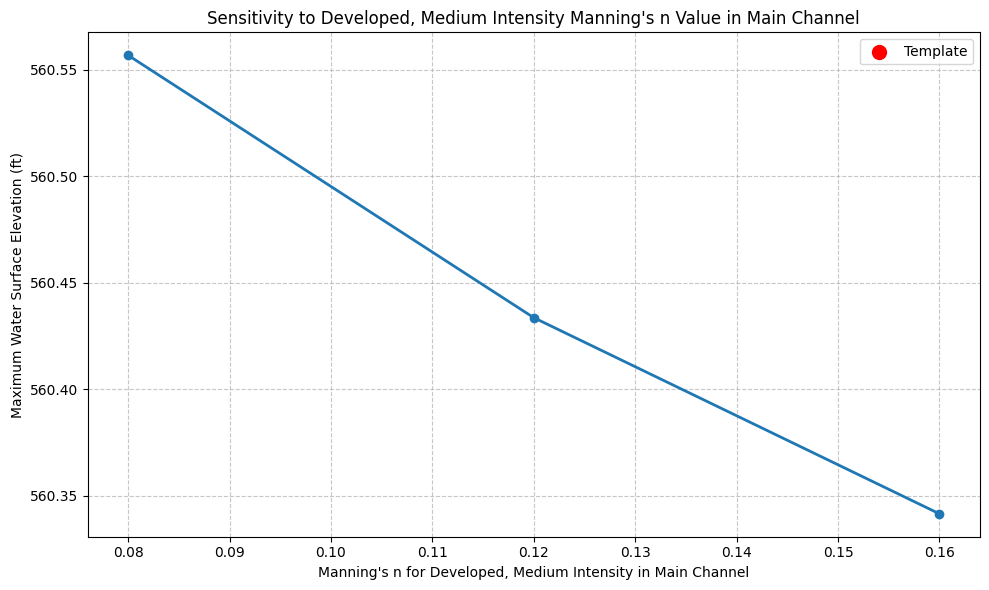

Created sensitivity plot for Developed, Medium Intensity in Main Channel


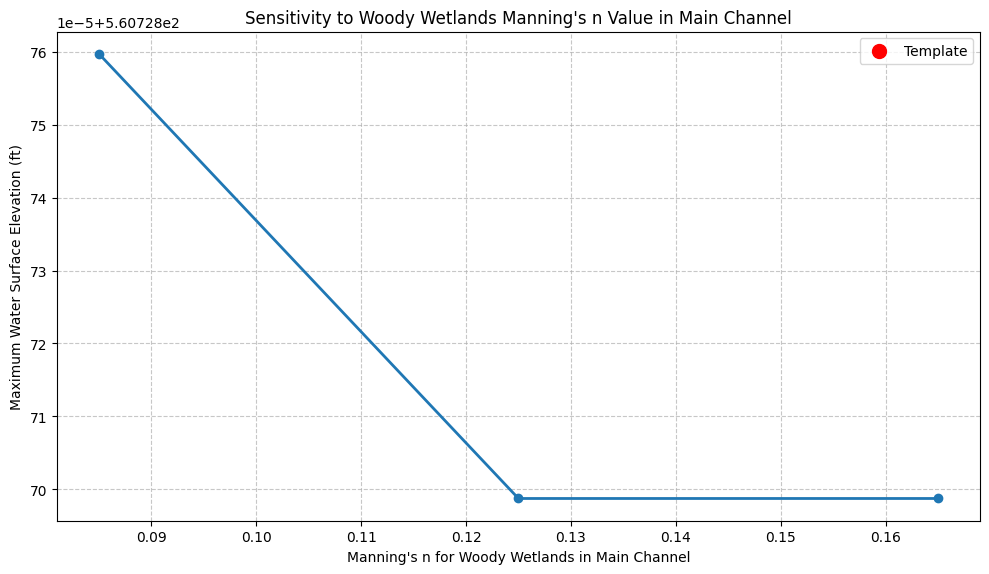

Created sensitivity plot for Woody Wetlands in Main Channel


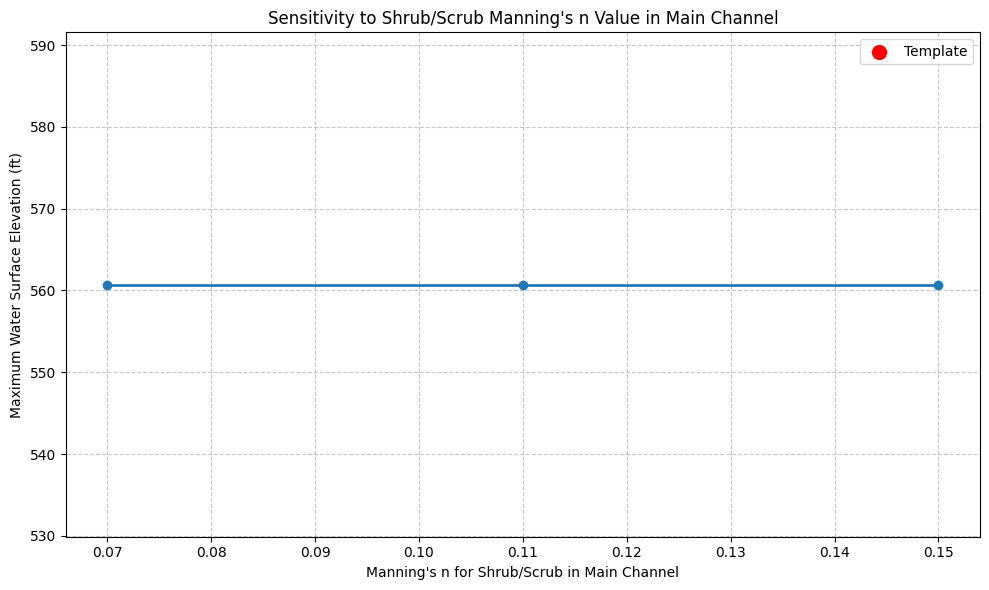

Created sensitivity plot for Shrub/Scrub in Main Channel


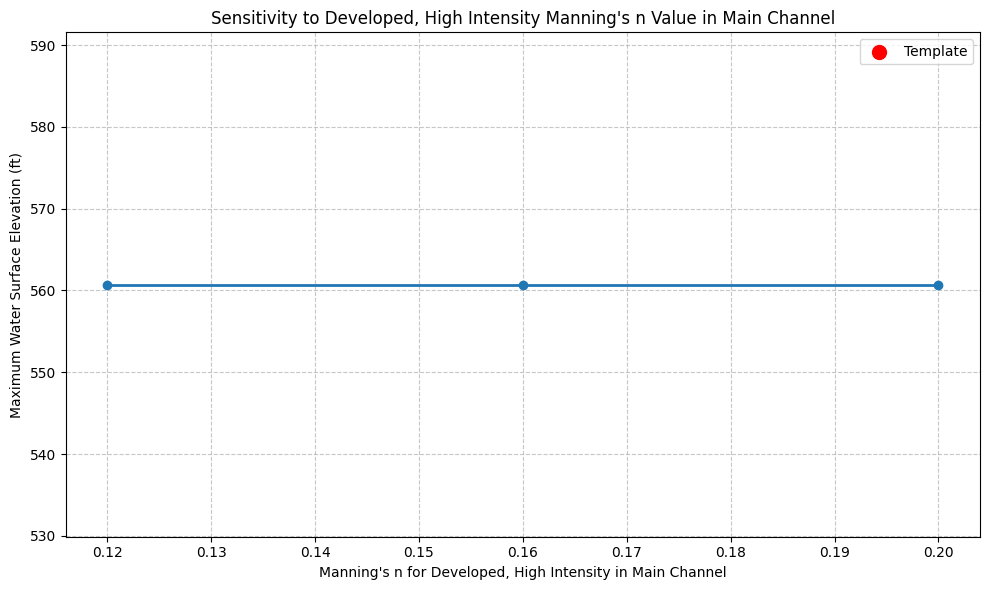

Created sensitivity plot for Developed, High Intensity in Main Channel


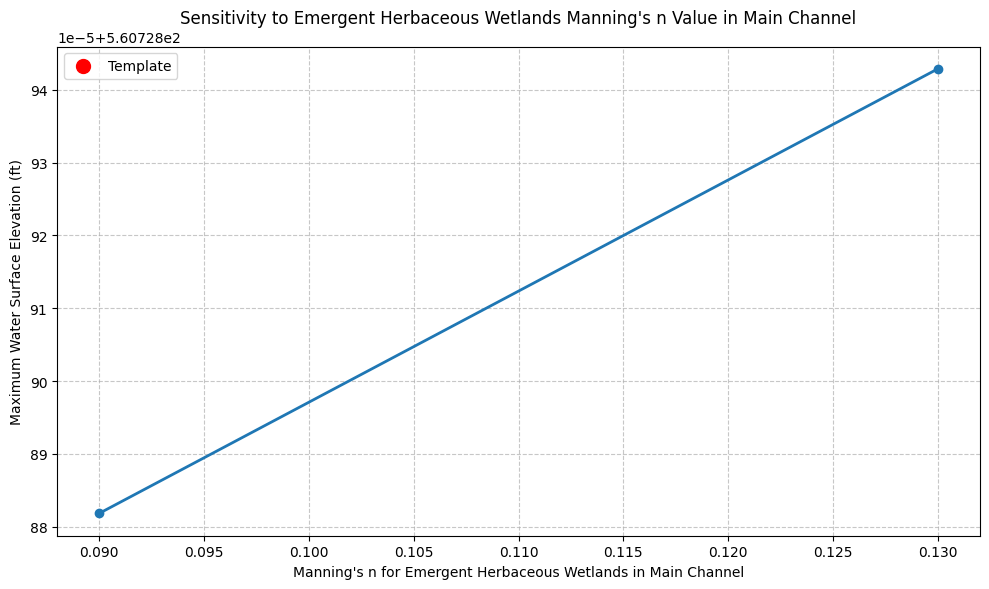

Created sensitivity plot for Emergent Herbaceous Wetlands in Main Channel


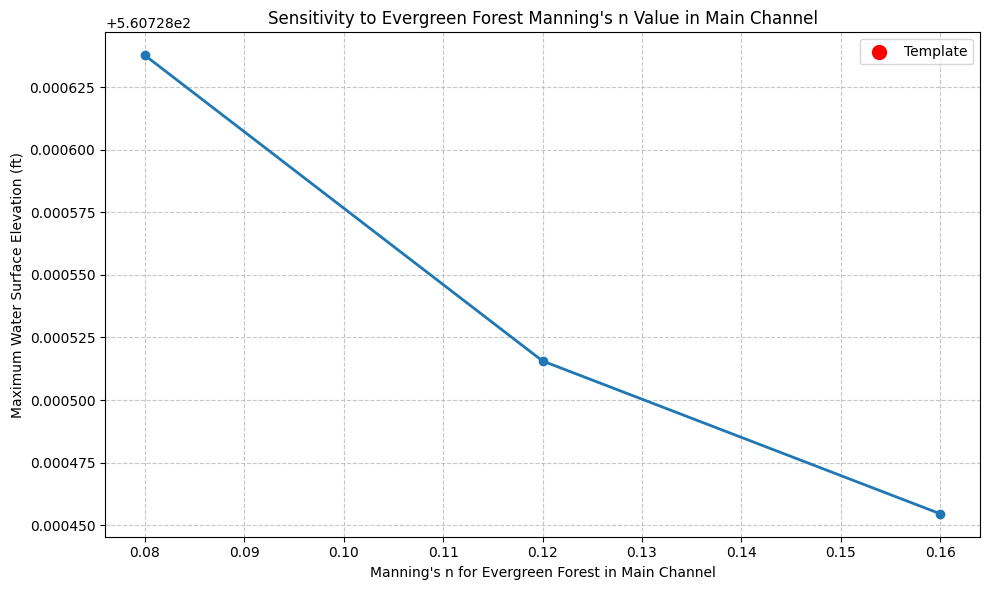

Created sensitivity plot for Evergreen Forest in Main Channel


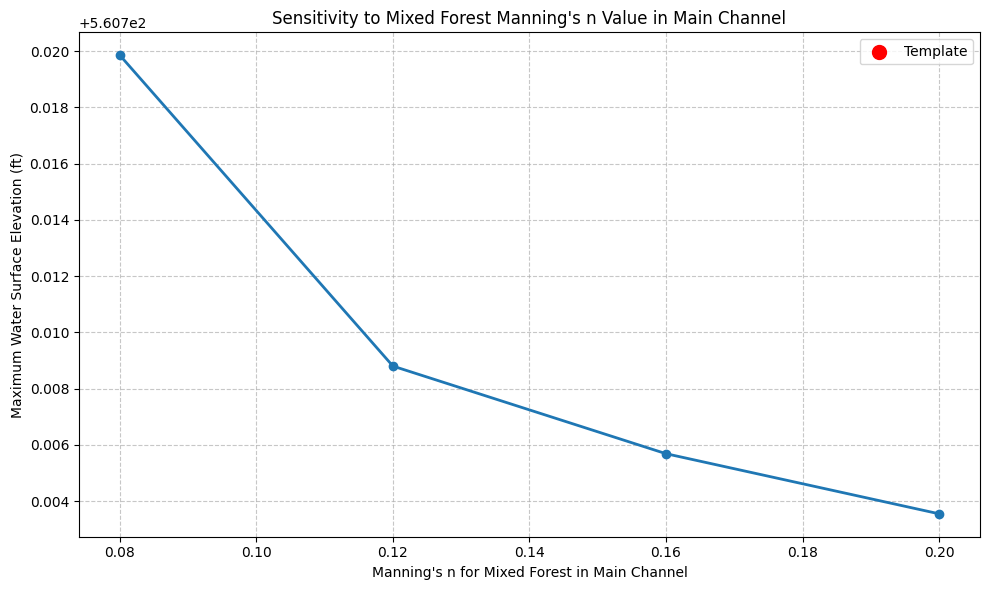

Created sensitivity plot for Mixed Forest in Main Channel


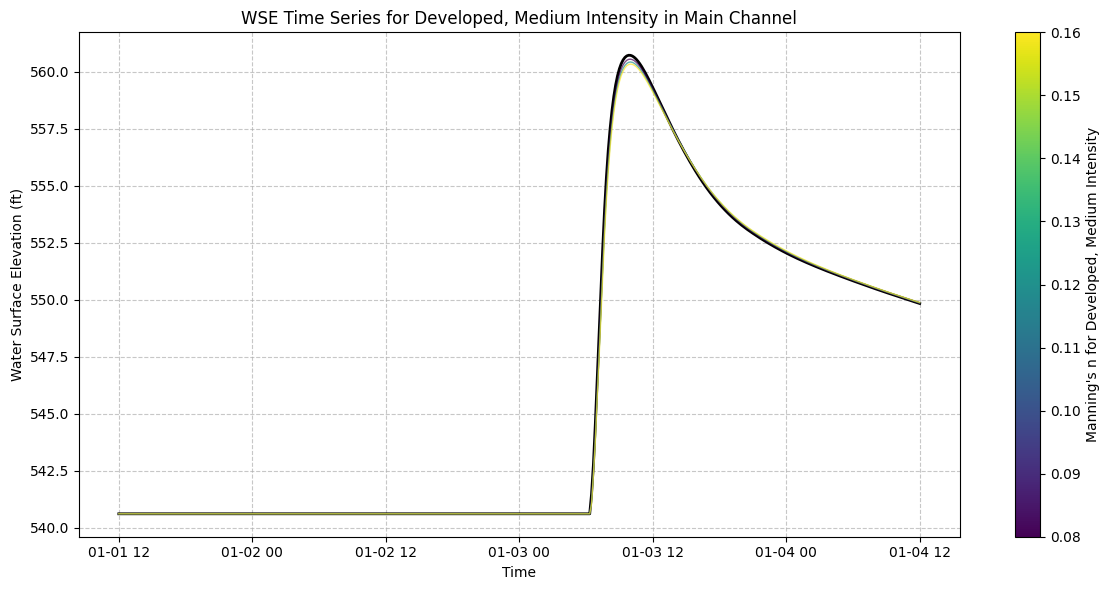

Created time series plot for Developed, Medium Intensity in Main Channel


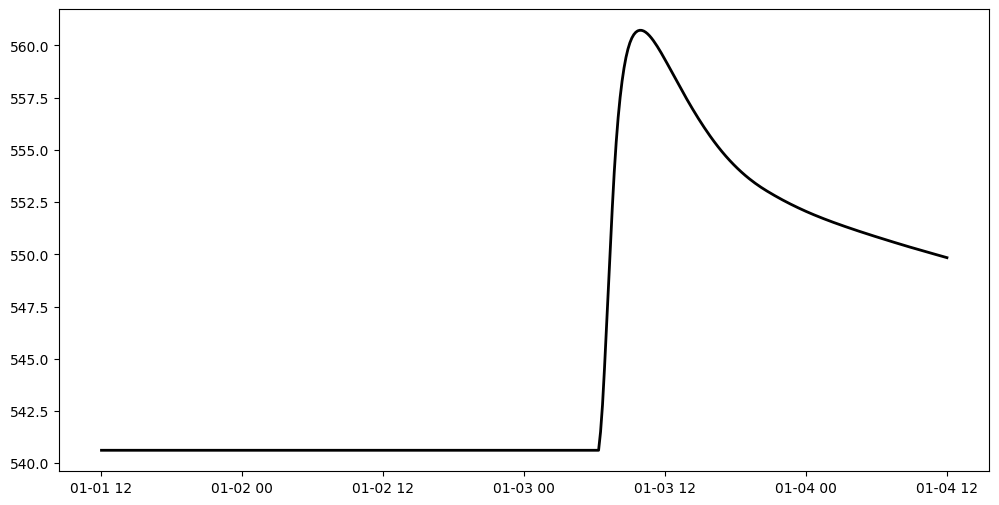

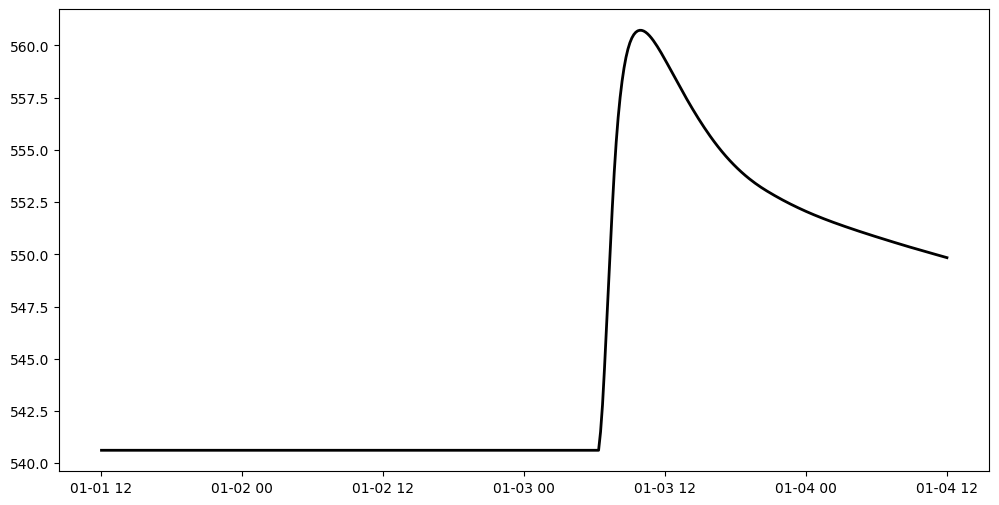

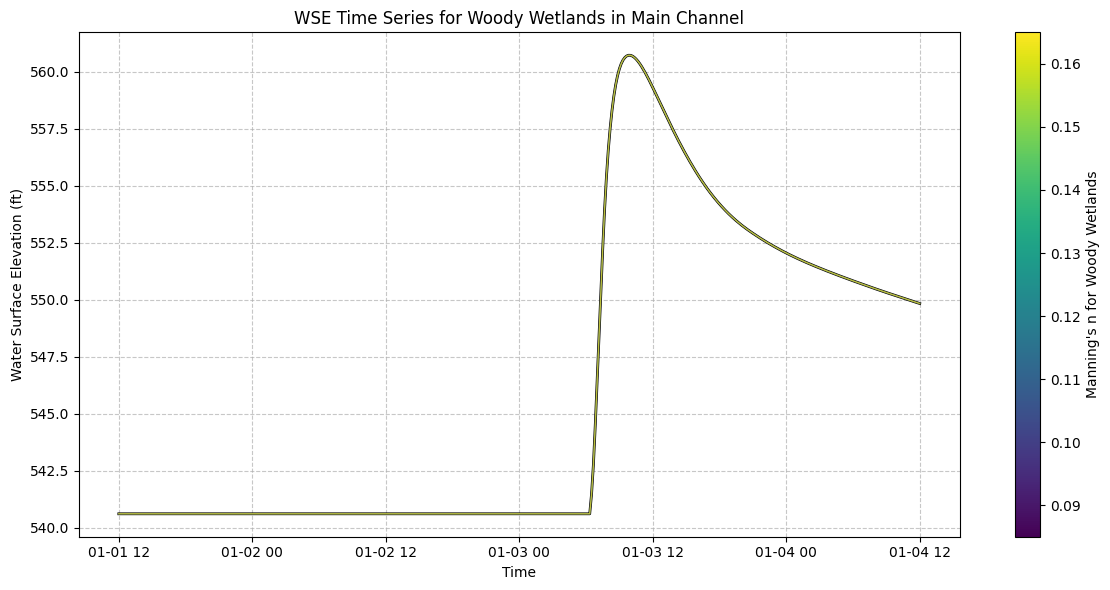

Created time series plot for Woody Wetlands in Main Channel


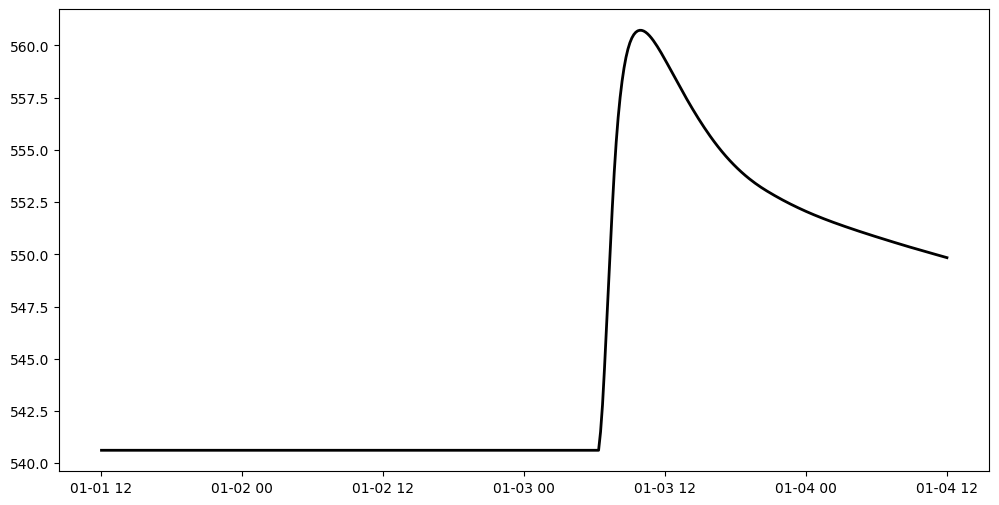

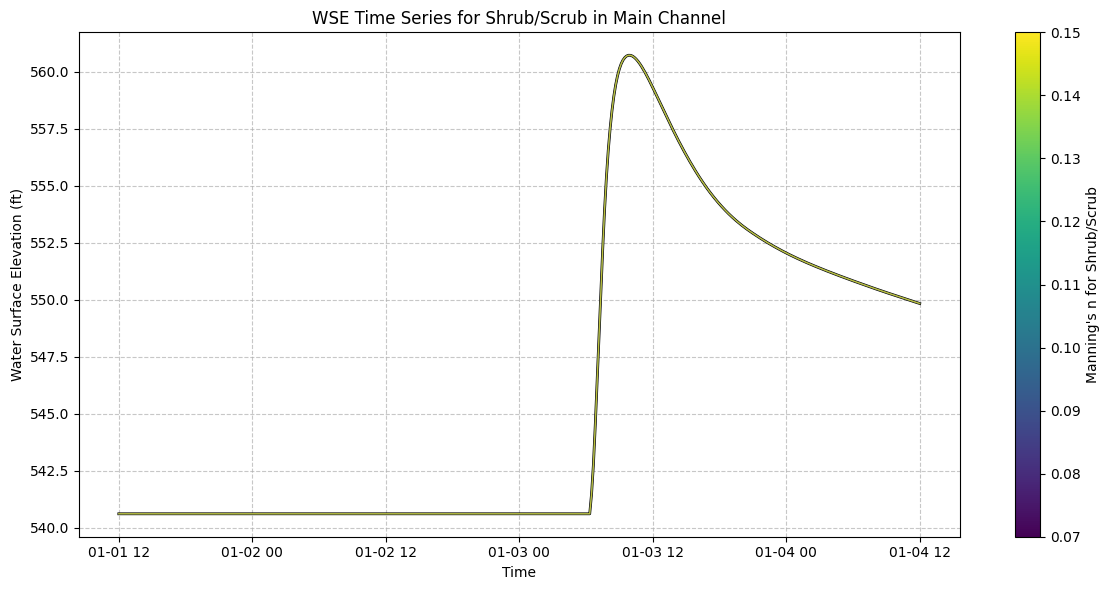

Created time series plot for Shrub/Scrub in Main Channel


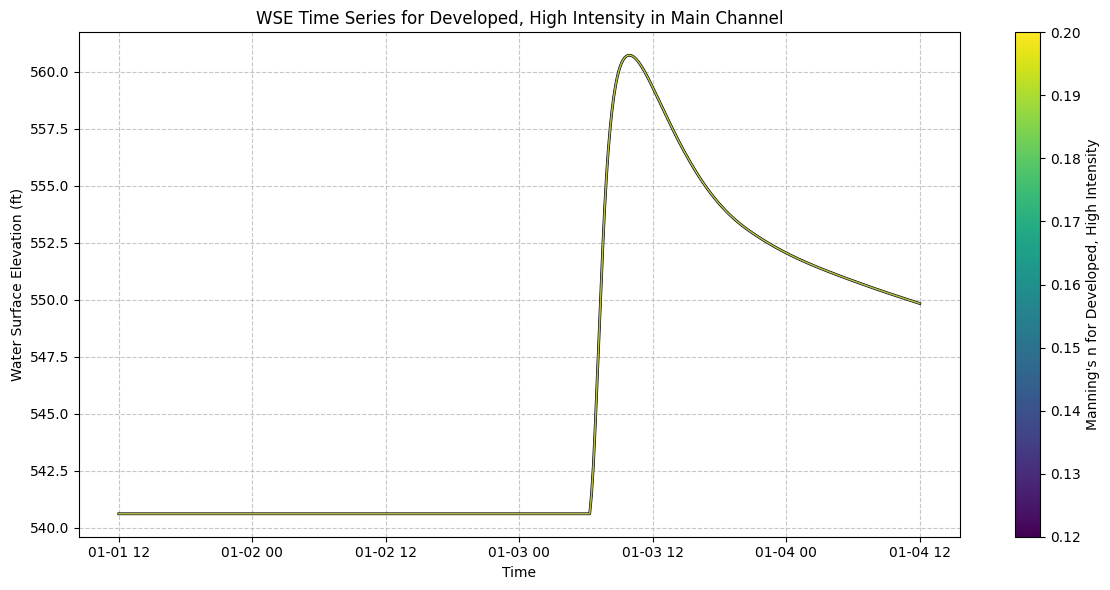

Created time series plot for Developed, High Intensity in Main Channel


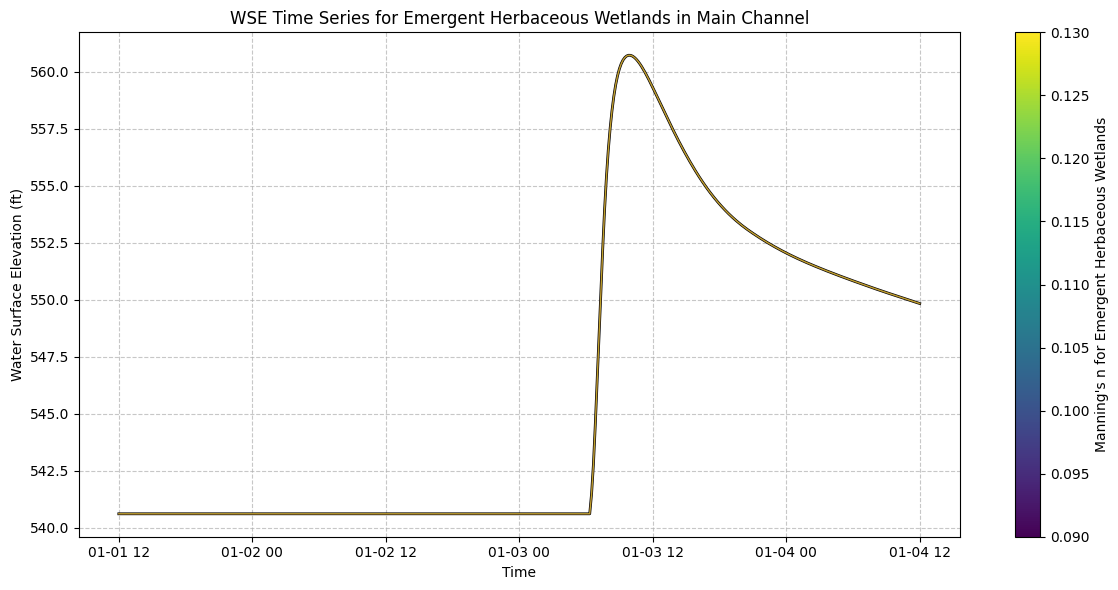

Created time series plot for Emergent Herbaceous Wetlands in Main Channel


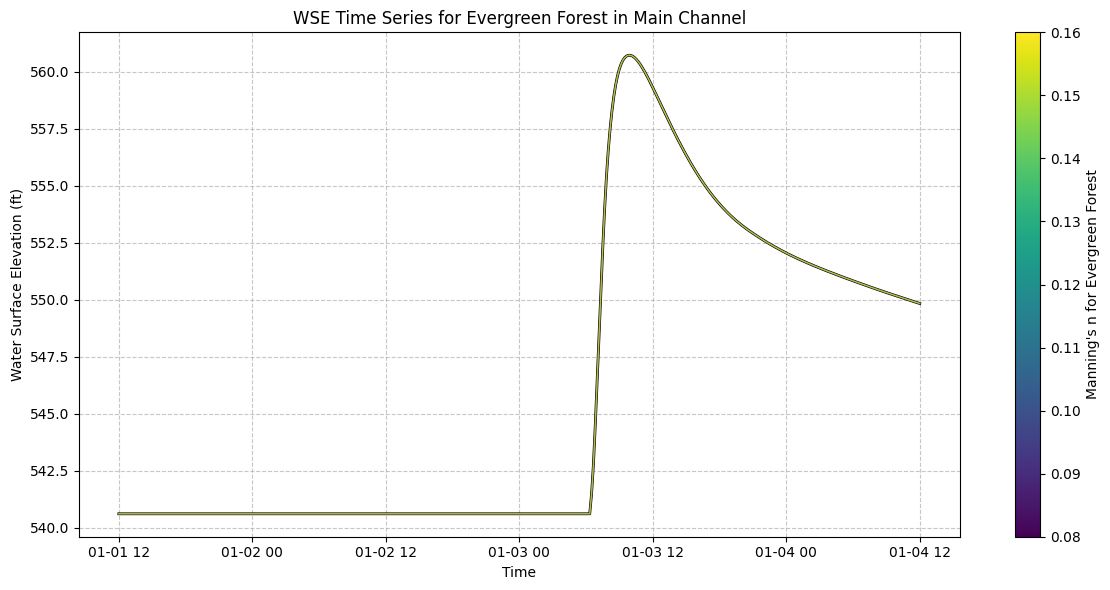

Created time series plot for Evergreen Forest in Main Channel


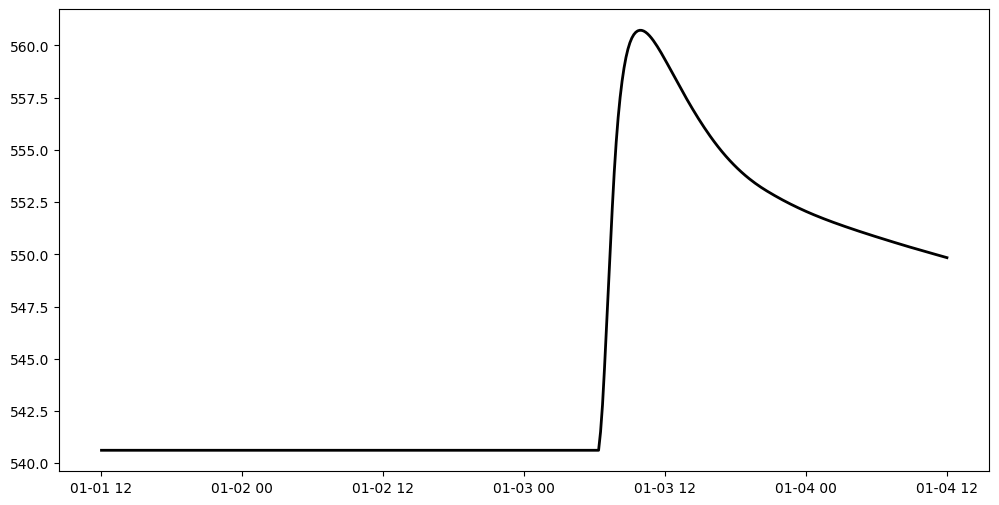

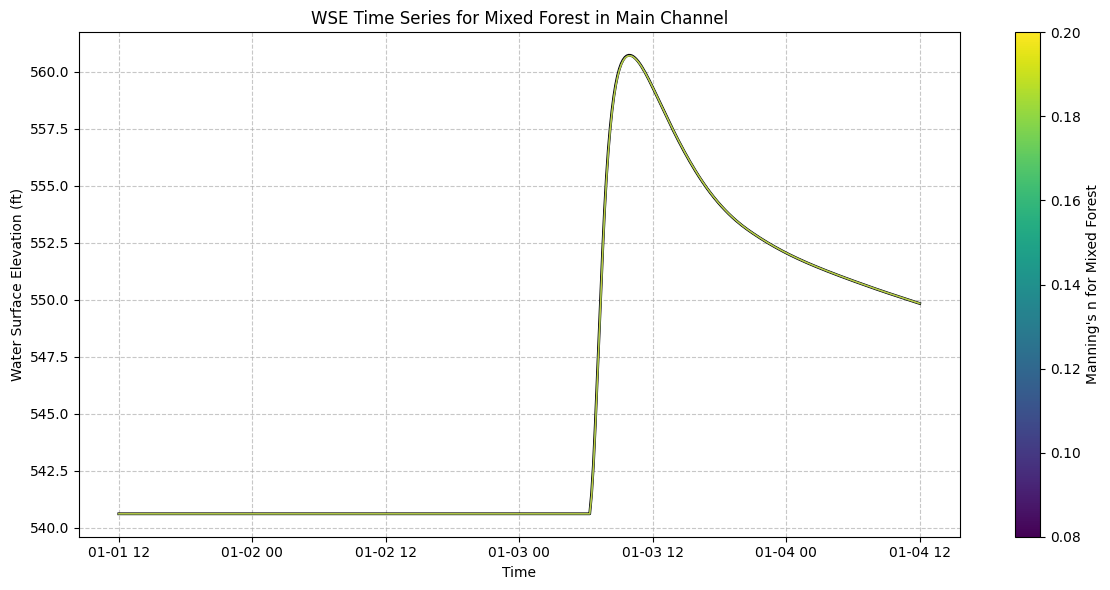

Created time series plot for Mixed Forest in Main Channel


In [15]:
# Example usage for Regional Overrides Sensitivity Analysis
# To run this, uncomment the code, adjust parameters as needed, and execute the cell

import shutil
from pathlib import Path

# 1. Define source and destination paths
#    (We use the original extracted project as source, not the BOMIS one)
source_project_folder = Path(RasExamples.extract_project(PROJECT_NAME, suffix="106"))
examples_root = source_project_folder.parent

# 2. Create a specific folder for Regional Override Multi-Interval Sensitivity (ROMIS)
project_folder = examples_root / f"{PROJECT_NAME}_ROMIS"

# Clean up if it already exists
if project_folder.exists():
    shutil.rmtree(project_folder)

# Copy the source project to the ROMIS folder
print(f"Creating dedicated ROMIS project folder...")
shutil.copytree(source_project_folder, project_folder)
print(f"Created: {project_folder}")

# 3. Initialize the ROMIS project
#    (This updates the global 'ras' object to point to this new folder, replacing the BOMIS context)
init_ras_project(project_folder, RAS_VERSION)

# Define parameters
template_plan = PLAN  # Plan 03 has regional overrides
point_of_interest = POINT_OF_INTEREST # Coordinates for regional analysis

# Execute the template plan first (required for mesh cell identification and result extraction)
print(f"Executing template plan {template_plan} before sensitivity analysis...")
RasCmdr.compute_plan(template_plan, num_cores=NUM_CORES)
print(f"Template plan {template_plan} execution complete.")

# Run the regional sensitivity analysis
run_region_sensitivity_results = individual_landuse_sensitivity_region(
    project_folder=project_folder,
    template_plan=template_plan,
    point_of_interest=point_of_interest,
    area_threshold=10.0,  # Only analyze land uses covering at least 10% of the mesh area
    interval=0.04,       # Adjust interval to reduce the number of test values
    max_workers=4,
    num_cores=NUM_CORES,
    region_name="Main Channel",  # Specify a region or set to None for all regions
    output_folder="Regional_Landuse_Sensitivity",
    n_ranges=manning_minmax_df
)


In [16]:
# Print summary information
if run_region_sensitivity_results:
    print("\nAnalysis complete! Results saved to:", run_region_sensitivity_results['output_folder'])
    if 'significant_landuses' in run_region_sensitivity_results:
        print("\nSignificant land uses analyzed in regions:")
        print(run_region_sensitivity_results['significant_landuses'][['Land Cover Type', 'Percentage']])


Analysis complete! Results saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_ROMIS\Regional_Landuse_Sensitivity

Significant land uses analyzed in regions:
                 Land Cover Type  Percentage
0    Developed, Medium Intensity   24.630900
1                         NoData   22.749712
2           Grassland/Herbaceous   20.516389
3                 Woody Wetlands   18.570300
4                     Open Water   18.546225
5                    Shrub/Scrub   18.425513
6      Developed, High Intensity   17.887623
7   Emergent Herbaceous Wetlands   16.761743
8               Evergreen Forest   14.198315
9          Developed, Open Space   13.342006
10                  Mixed Forest   10.901125


-----

## Regional Override Sensitivity Results

### Interpreting Regional Results

The following plots show sensitivity analysis results for regional Manning's n overrides from the BaldEagleCrkMulti2D example project (Plan 03). The plots follow the same format as the base sensitivity results, but focus on parameters within specific calibration regions.

**Key Differences from Base Results:**
- Plots are labeled with both land cover type AND region name
- Changes affect only the specified region, not the entire mesh
- Sensitivity may be higher or lower depending on the hydraulic importance of the region
- Useful for understanding which regional parameters require the most careful calibration

**Regional vs. Base Comparison:**
- Compare the magnitude of water surface changes between regional and base sensitivity
- Regional parameters that cause large changes should be prioritized in calibration
- If a land cover has low sensitivity in a particular region, it may be acceptable to use default values

**Application to Your Models:**
- Identify which regions have the strongest influence on your points of interest
- Focus calibration efforts on high-sensitivity regions
- Consider simplifying regions with low sensitivity

---

### Results from BaldEagleCrkMulti2D, Plan 03 (Main Channel Region)

---

# Summary and Best Practices

## Key Takeaways

### Analysis Methodology

This notebook demonstrated two complementary approaches to Manning's n sensitivity analysis:

1. **Base Override Sensitivity**: Tests global land cover roughness parameters across the entire 2D mesh
2. **Regional Override Sensitivity**: Tests localized roughness parameters within specific calibration regions

Both approaches use literature-based ranges to ensure physically reasonable parameter variations and automatically generate comprehensive visualizations.

### Practical Applications

**When to Use Base Sensitivity:**
- Initial model exploration and parameter importance ranking
- Models with uniform land cover distributions
- Assessing global calibration uncertainty
- Identifying which land covers dominate model response

**When to Use Regional Sensitivity:**
- Main channel calibration (use bulk approach from notebook 105)
- Localized parameter testing in specific hydraulic zones
- Floodplain region calibration with distinct characteristics
- Focused calibration in areas of interest

### Calibration Workflow Recommendations

1. **Start with base sensitivity** to identify globally important land covers
2. **Rank parameters by sensitivity** - focus on land covers causing largest water surface changes
3. **Use regional sensitivity** for localized refinement in hydraulically important areas
4. **Iterate with observed data** - compare sensitivity results against measured water surfaces
5. **Document assumptions** - record which parameters were adjusted and why

### Computational Efficiency Tips

**Plan Count Management:**
- Use larger `interval` values (e.g., 0.02-0.05) to reduce plan count
- Increase `area_threshold` to focus only on dominant land covers
- Target specific regions rather than analyzing all regions simultaneously
- HEC-RAS limits projects to 99 plans maximum

**Parallel Execution:**
- Balance `max_workers` and `num_cores` based on available CPU and RAM
- Rule of thumb: `max_workers * num_cores ≤ total_logical_cores`
- Monitor system resources during execution
- Consider sequential execution for very large or memory-intensive models

### Output Files

Each analysis creates a structured output folder containing:
- `scenarios.csv`: Complete plan inventory with parameter values
- `max_water_surface_summary.csv`: Peak water surface elevations for all scenarios
- `timeseries_*.csv`: Complete hydrographs for each scenario
- `sensitivity_*.png`: Parameter sensitivity plots
- `timeseries_*.png`: Time series comparison plots

### Next Steps

- **Compare with observed data**: Use sensitivity plots to guide calibration toward measured values
- **Uncertainty quantification**: Analyze the range of results to understand prediction uncertainty
- **Spatial analysis**: Extract results at multiple points to understand spatial variability
- **Multi-objective calibration**: Consider multiple performance metrics beyond peak water surface

### Related Notebooks

- **Notebook 105**: Bulk Manning's n sensitivity analysis (recommended for main channel calibration)
- **Notebook 09**: Plan parameter operations for additional customization
- **Notebook 08**: Parallel execution techniques for large-scale analyses

---

## References

**Manning's n Value Resources:**
- Chow, V.T. (1959). Open-Channel Hydraulics. McGraw-Hill
- Arcement, G.J., & Schneider, V.R. (1989). Guide for Selecting Manning's Roughness Coefficients. USGS Water Supply Paper 2339
- HEC-RAS Hydraulic Reference Manual (current version)

**Sensitivity Analysis:**
- Saltelli, A., et al. (2008). Global Sensitivity Analysis: The Primer. Wiley
- Tate, E., et al. (2015). Uncertainty Analysis for Flood Risk Assessment. Natural Hazards

---

*End of Notebook*
